In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from numpy import sign
from tqdm import tqdm
import os
import json

In [ ]:
# Define hyperparameters
RANDOM_SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
BETAS = (0.5, 0.99)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int = 100, img_channels: int = 1):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, img_channels, 4, 2, 1, bias=False),
            nn.Conv2d(img_channels, img_channels, 5, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        batch_size = z.size(0)
        z = z.view(batch_size, self.latent_dim, 1, 1)
        img = self.model(z)
        return img[:, :, 2:-2, 2:-2]

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels: int = 1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),  # [64, 14, 14]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),           # [128, 7, 7]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),          # [256, 4, 4]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)             # [1, 1, 1]
        )

    def forward(self, img):
        logits = self.model(img)
        return logits.view(-1, 1)

In [ ]:
class DiscriminatorLoss(nn.Module):
    def __init__(self, lambda_gp: float = 10.0):
        super(DiscriminatorLoss, self).__init__()
        self.bce_logits = nn.BCEWithLogitsLoss()
        self.lambda_gp = lambda_gp  # Gradient penalty weight

    def forward(self,
                discriminator: nn.Module,
                real_images: torch.Tensor,
                fake_images: torch.Tensor,
                real_outputs: torch.Tensor,
                fake_outputs: torch.Tensor) -> torch.Tensor:
        """
        Args:
            discriminator: The discriminator model (for gradient penalty computation)
            real_images: Batch of real images [batch_size, 1, 28, 28]
            fake_images: Batch of fake images [batch_size, 1, 28, 28]
            real_outputs: Discriminator logits for real images [batch_size, 1]
            fake_outputs: Discriminator logits for fake images [batch_size, 1]
        Returns:
            Total loss (BCE + gradient penalty)
        """
        # BCE Loss
        real_labels = torch.ones_like(real_outputs)
        fake_labels = torch.zeros_like(fake_outputs)
        real_loss = self.bce_logits(real_outputs, real_labels)
        fake_loss = self.bce_logits(fake_outputs, fake_labels)
        bce_loss = (real_loss + fake_loss) / 2

        # Gradient Penalty
        alpha = torch.rand(real_images.size(0), 1, 1, 1, device=real_images.device)
        interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
        d_interpolates = discriminator(interpolates)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = self.lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return bce_loss + gradient_penalty

class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        self.bce_logits = nn.BCEWithLogitsLoss()

    def forward(self, discriminator_pred: torch.Tensor) -> torch.Tensor:
        """
        Args:
            discriminator_pred: Output logits from discriminator for fake images [batch_size, 1]
        Returns:
            Loss value (scalar tensor)
        """
        real_labels = torch.ones_like(discriminator_pred)  # Target is 1 (fake images classified as real)
        return self.bce_logits(discriminator_pred, real_labels)

In [ ]:
class AdaptiveDiffusionScheduler:
    def __init__(self, beta_0=1e-4, beta_f=2e-2, max_T=1000, d_target=0.6, smoothing=0.999, C=0.7, device='cuda'):
        self.beta_0 = beta_0
        self.beta_f = beta_f
        self.T = max_T
        self.max_T = max_T
        self.device = device
        self.betas = torch.linspace(beta_0, beta_f, max_T).to(device)
        self.alphas = (1 - self.betas).to(device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)
        self.d_target = d_target
        self.smoothing = smoothing
        self.r_d = d_target
        self.C = C

    def update_schedule(self, des_loss: float) -> None:
        self.r_d = (1 - self.smoothing) * self.r_d + self.smoothing * des_loss
        self.T = int(self.T + self.C * (self.r_d - self.d_target))
        self.T = max(1, min(self.T, self.max_T))
        self.betas = torch.linspace(self.beta_0, self.beta_f, self.T).to(self.device)
        self.alphas = (1 - self.betas).to(self.device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(self.device)

    def sample_timesteps(self, batch_size: int) -> torch.Tensor:
        current_T = min(self.T, len(self.alphas_cumprod) - 1)
        return torch.randint(0, current_T, (batch_size,), dtype=torch.long, device=self.device)

    def apply_diffusion(self, imgs: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        timesteps = torch.clamp(timesteps, 0, len(self.alphas_cumprod) - 1)
        alphas_cumprod_t = self.alphas_cumprod[timesteps].view(-1, 1, 1, 1)
        noise = torch.randn_like(imgs)
        return torch.sqrt(alphas_cumprod_t) * imgs + torch.sqrt(1 - alphas_cumprod_t) * noise


In [ ]:
def save_checkpoint(generator, discriminator, Goptimizer, Doptimizer, epoch, save_dir="/kaggle/working/models"):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint = {
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "Goptimizer_state_dict": Goptimizer.state_dict(),
        "Doptimizer_state_dict": Doptimizer.state_dict()
    }
    save_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved at {save_path}")

def load_checkpoint(generator, discriminator, Goptimizer, Doptimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    Goptimizer.load_state_dict(checkpoint["Goptimizer_state_dict"])
    Doptimizer.load_state_dict(checkpoint["Doptimizer_state_dict"])

    print(f"Checkpoint loaded from {checkpoint_path}. Resuming from epoch {checkpoint['epoch']}.")

    return checkpoint["epoch"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def inference(generator_output, num_images=16, title="Generated Images", save_path=None):
    """
    Visualize and optionally save a batch of images from the generator output.

    Args:
        generator_output (torch.Tensor): Output from the generator [batch_size, 1, 28, 28]
        num_images (int): Number of images to display (default: 16)
        title (str): Title for the plot
        save_path (str, optional): Path to save the image (e.g., "output.png"), None if no save
    """
    # Ensure we don’t exceed the batch size
    batch_size = generator_output.size(0)
    num_images = min(num_images, batch_size)

    # Convert to CPU and detach from computation graph
    images = generator_output[:num_images].detach().cpu()

    # Rescale from [-1, 1] to [0, 1] (since generator uses Tanh)
    images = (images + 1) / 2

    # Remove channel dimension and convert to numpy [num_images, 28, 28]
    images = images.squeeze(1).numpy()

    # Set up the plot
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.suptitle(title, fontsize=16)

    # Flatten axes array for easy iteration if num_images > 1
    axes = axes.flatten() if num_images > 1 else [axes]

    # Plot each image
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')

    # Hide any extra axes
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title

    if save_path:
        plt.savefig(save_path)
        print(f"Image saved to {save_path}")


    # Display the plot
    plt.show()

Epoch 1/50: 100%|██████████| 1875/1875 [00:56<00:00, 33.02it/s]


Image saved to images/output_0.png


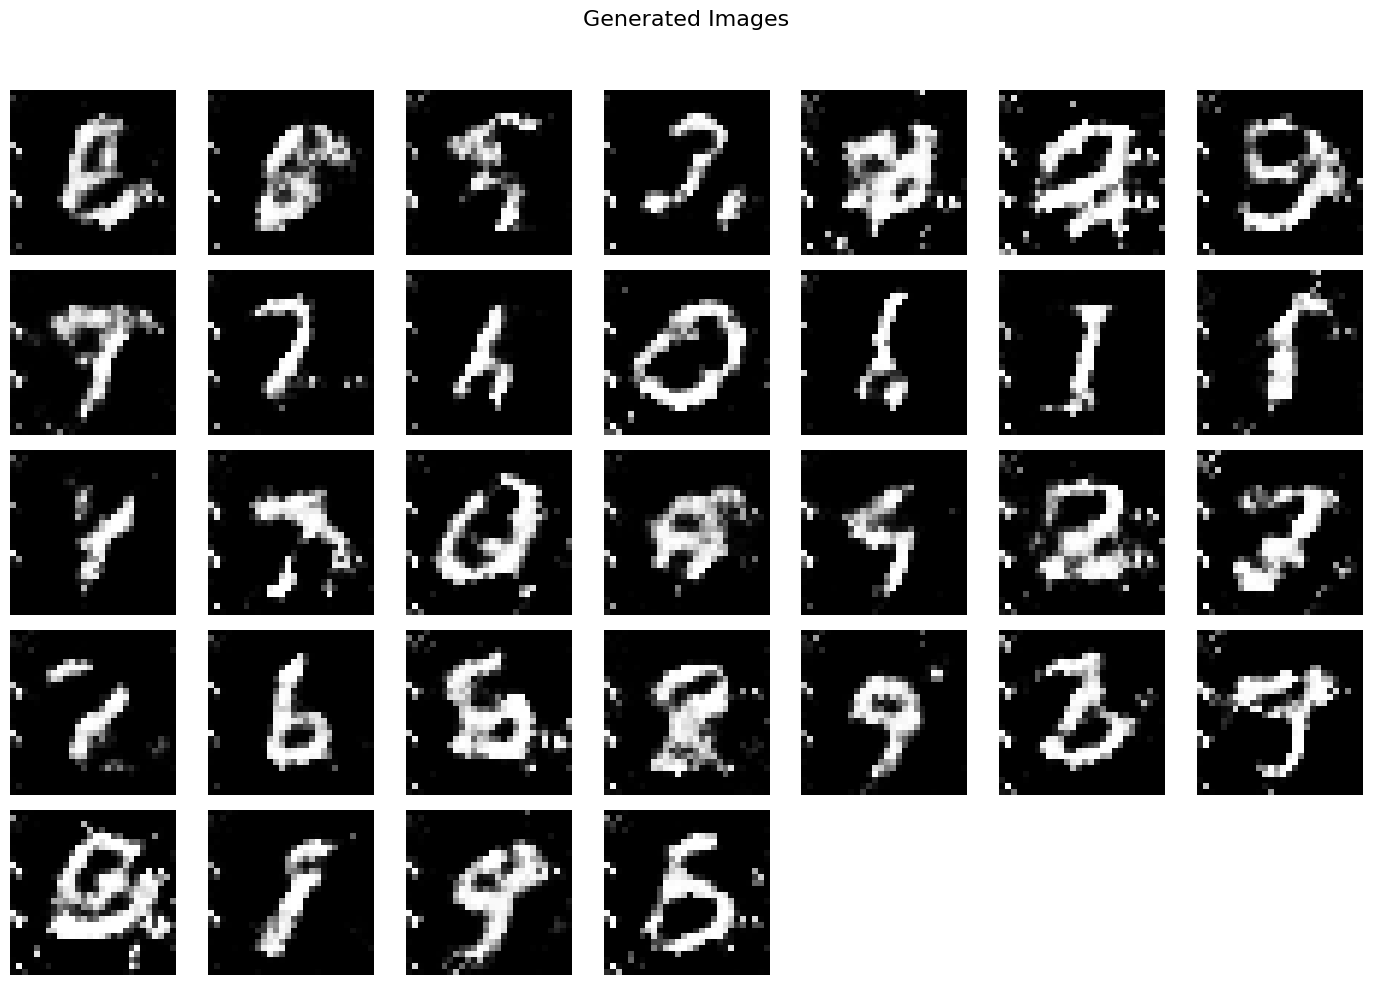

Checkpoint saved at models/checkpoint_epoch_1.pt
Epoch 1: G Loss: 0.862936, D Loss: 0.751525


Epoch 2/50: 100%|██████████| 1875/1875 [00:56<00:00, 33.17it/s]


Image saved to images/output_1.png


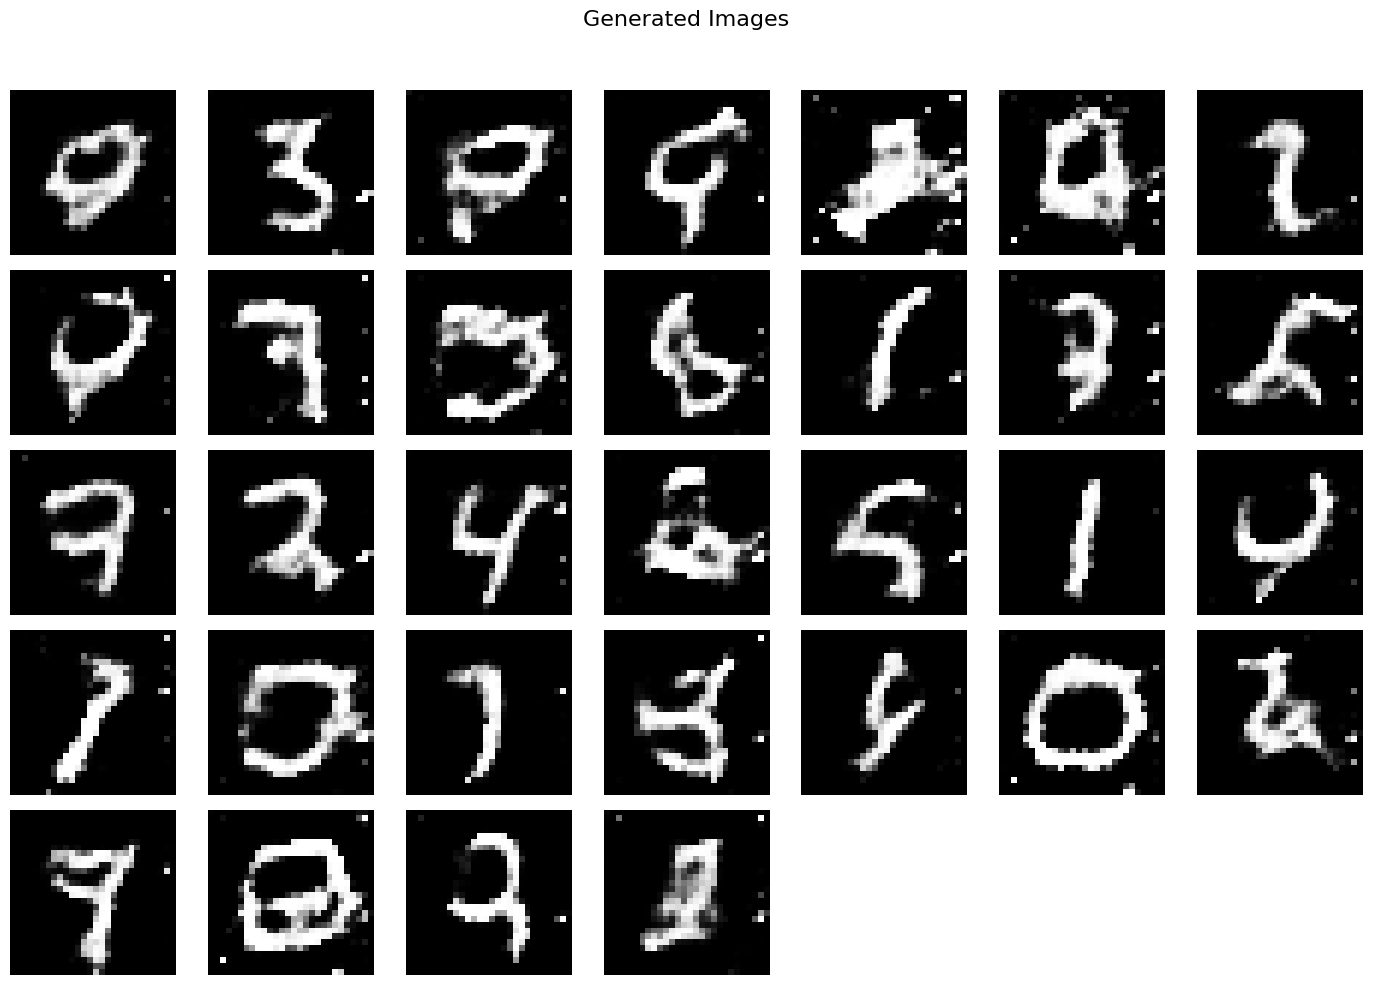

Checkpoint saved at models/checkpoint_epoch_2.pt
Epoch 2: G Loss: 0.754946, D Loss: 0.730013


Epoch 3/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.63it/s]


Image saved to images/output_2.png


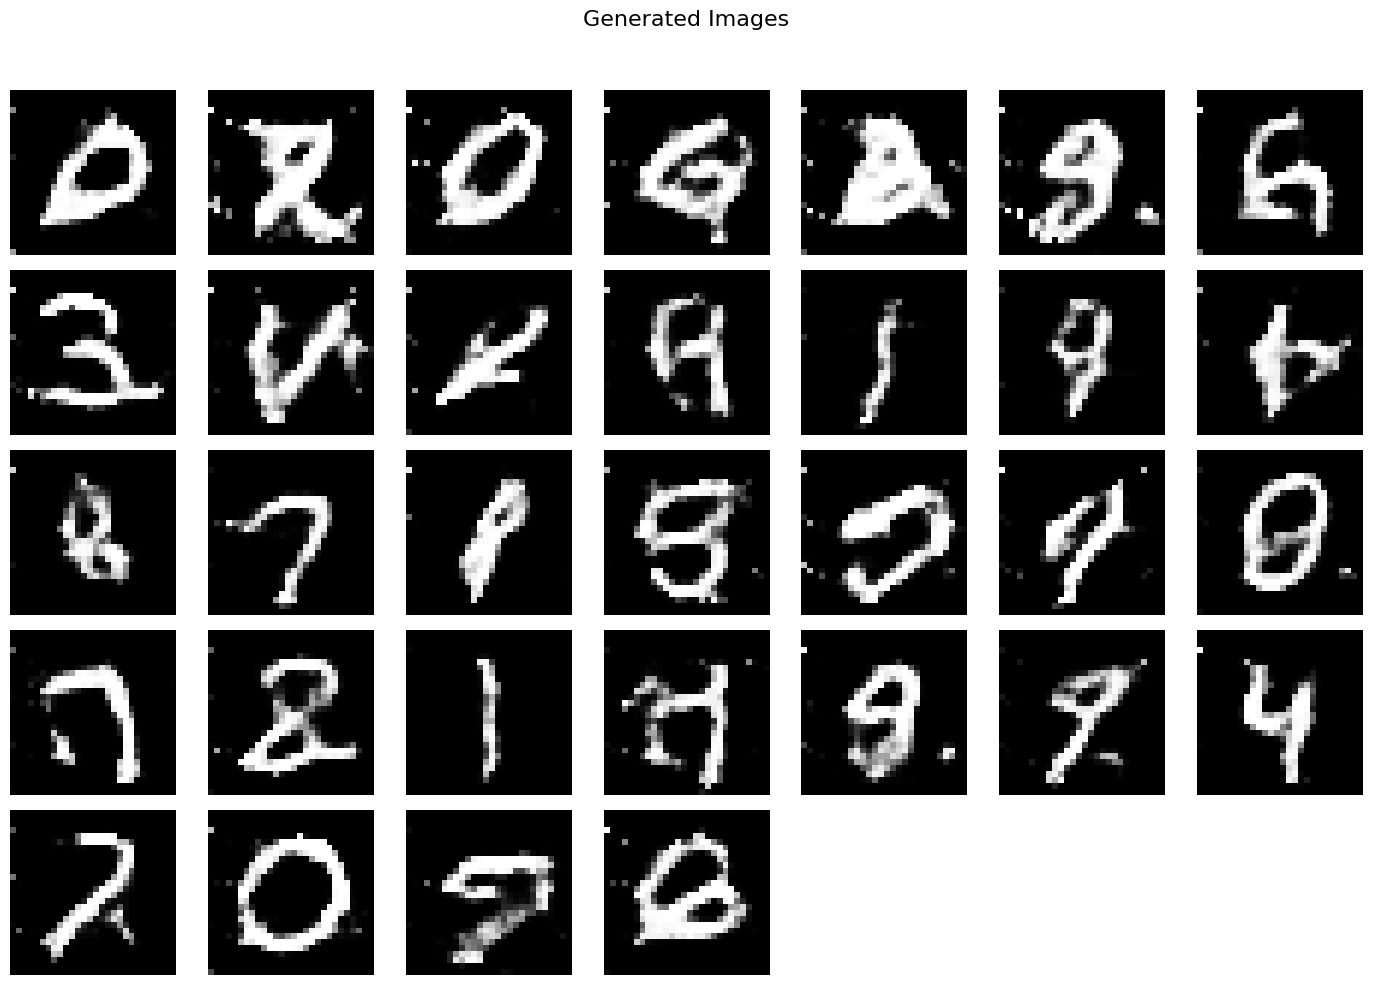

Checkpoint saved at models/checkpoint_epoch_3.pt
Epoch 3: G Loss: 0.741984, D Loss: 0.717555


Epoch 4/50: 100%|██████████| 1875/1875 [00:56<00:00, 33.22it/s]


Image saved to images/output_3.png


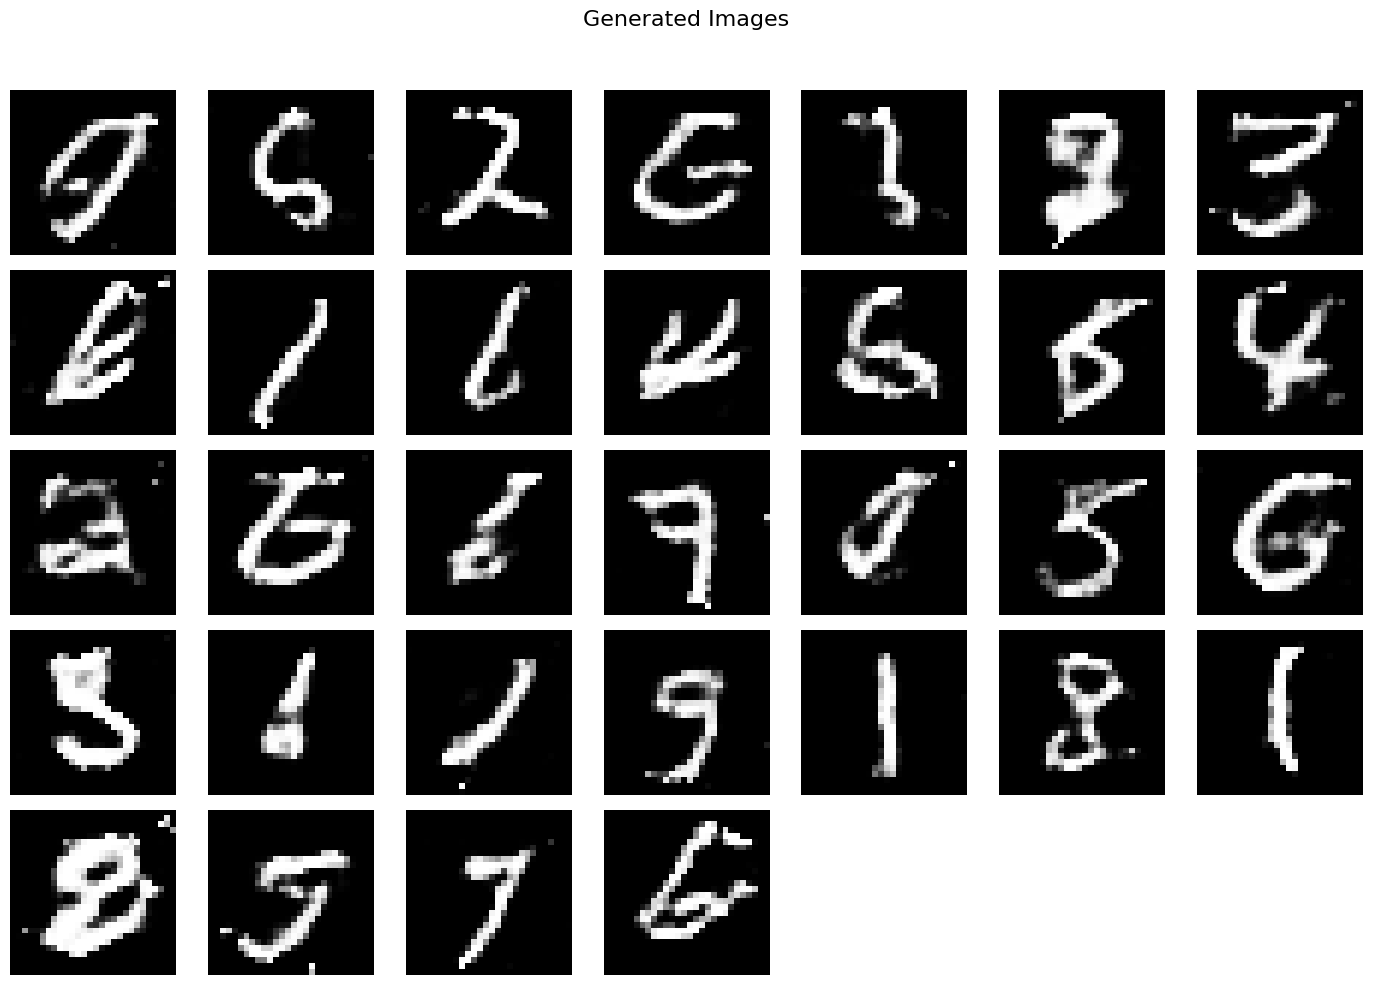

Checkpoint saved at models/checkpoint_epoch_4.pt
Epoch 4: G Loss: 0.731868, D Loss: 0.711316


Epoch 5/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.76it/s]


Image saved to images/output_4.png


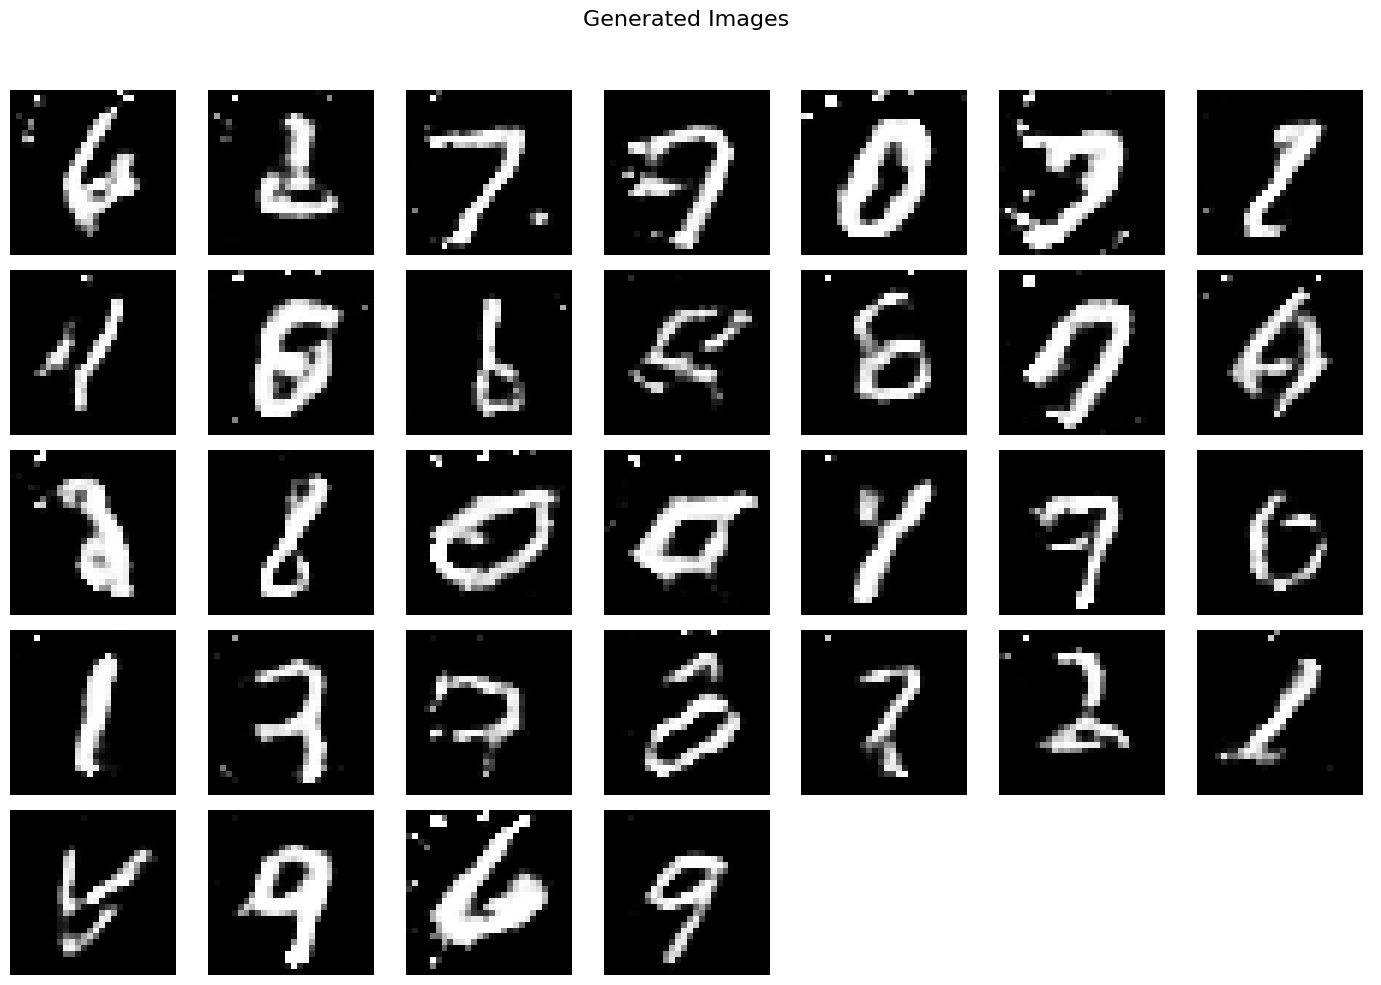

Checkpoint saved at models/checkpoint_epoch_5.pt
Epoch 5: G Loss: 0.730537, D Loss: 0.708376


Epoch 6/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.51it/s]


Image saved to images/output_5.png


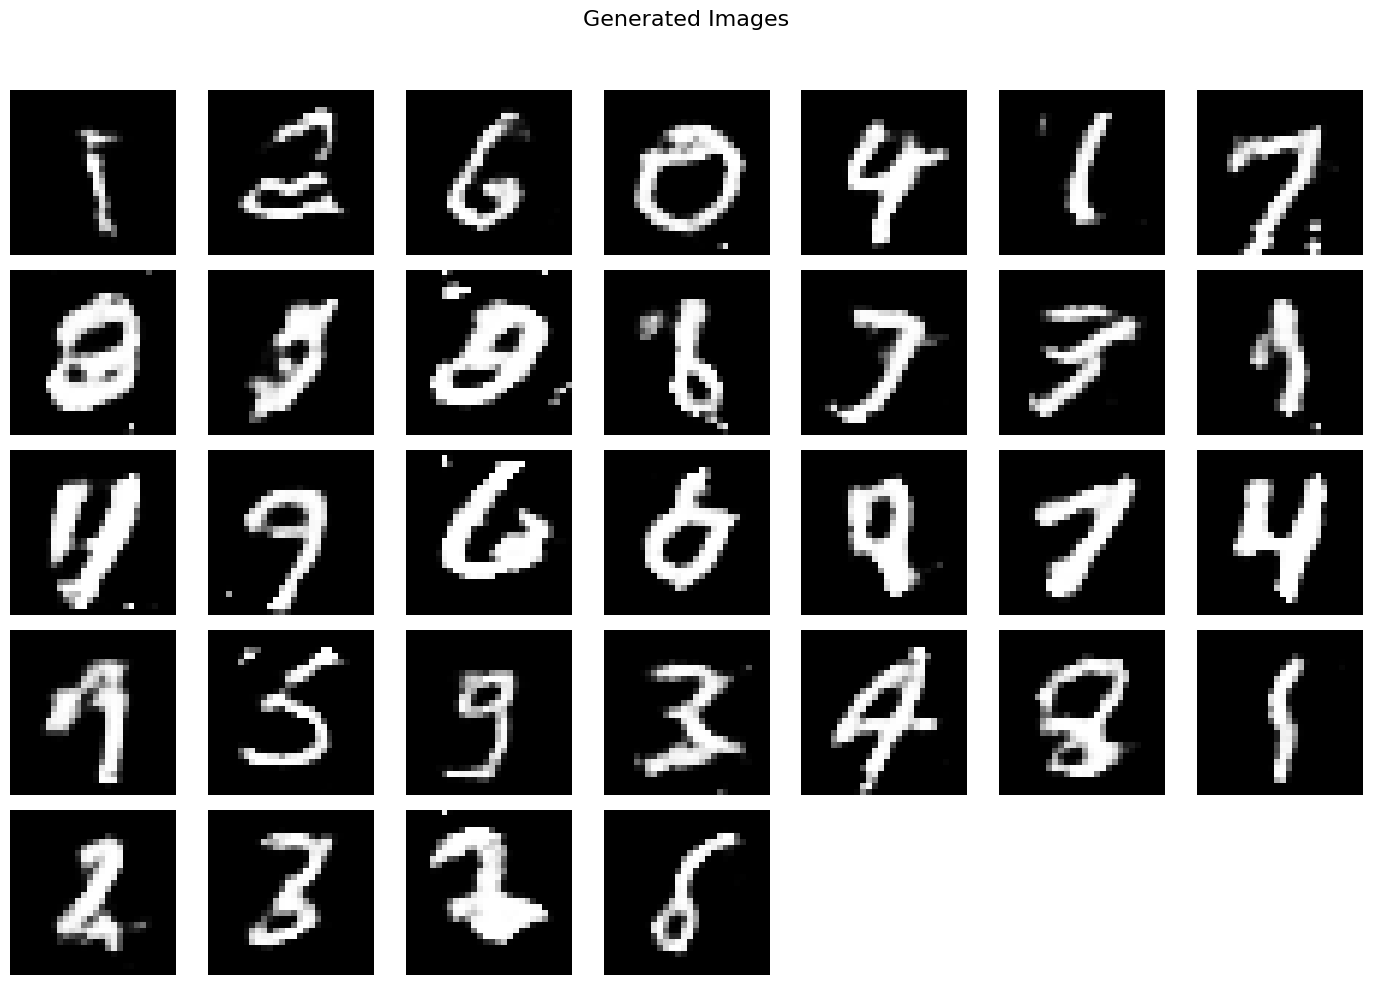

Checkpoint saved at models/checkpoint_epoch_6.pt
Epoch 6: G Loss: 0.727823, D Loss: 0.704808


Epoch 7/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.74it/s]


Image saved to images/output_6.png


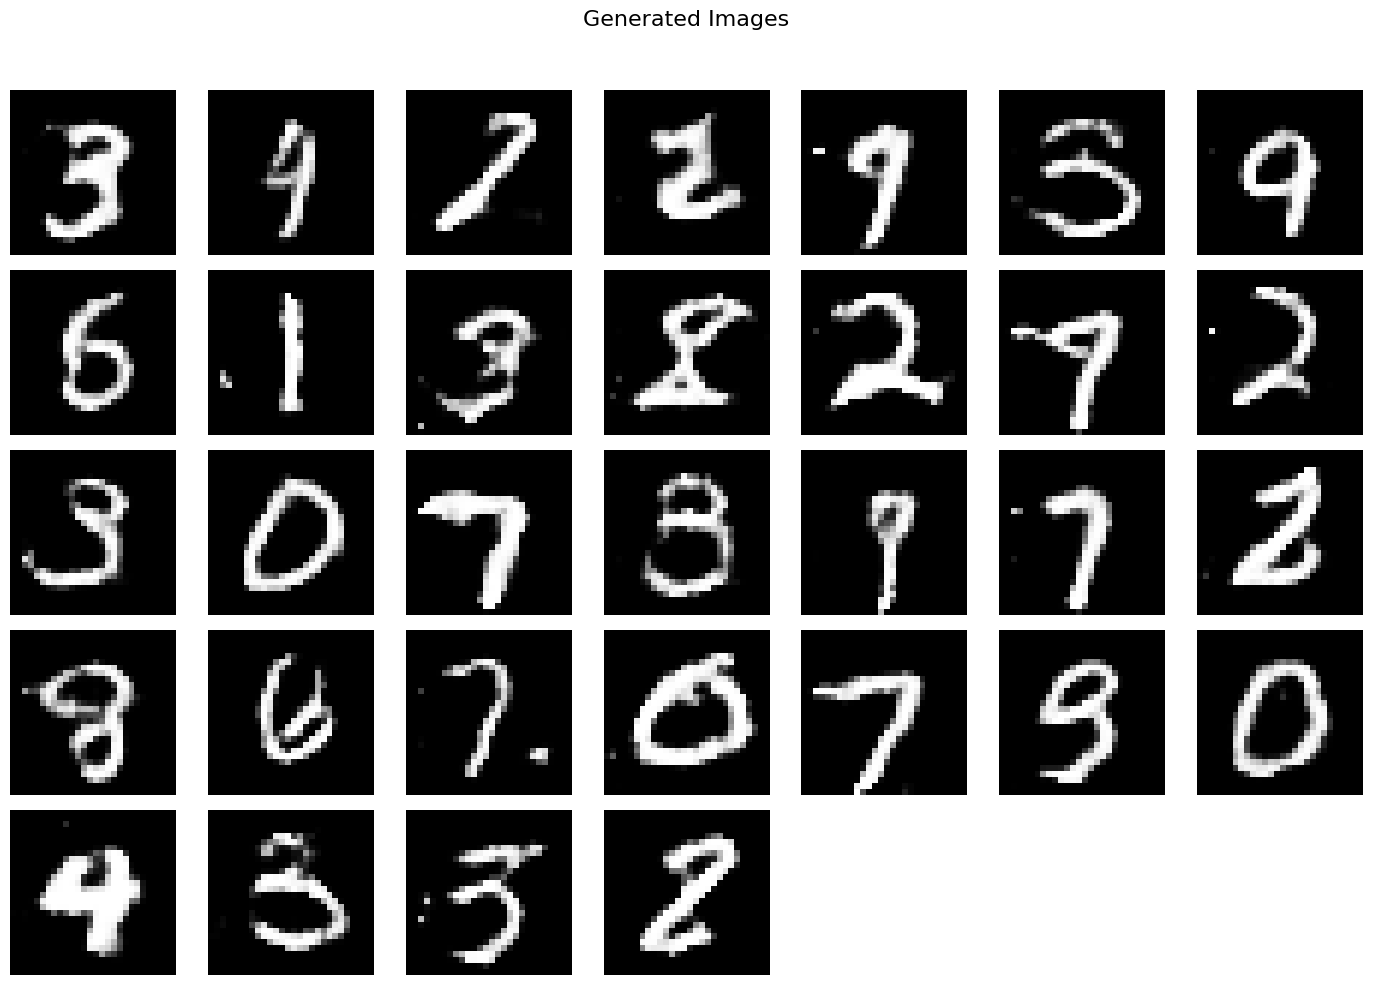

Checkpoint saved at models/checkpoint_epoch_7.pt
Epoch 7: G Loss: 0.729028, D Loss: 0.702967


Epoch 8/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.50it/s]


Image saved to images/output_7.png


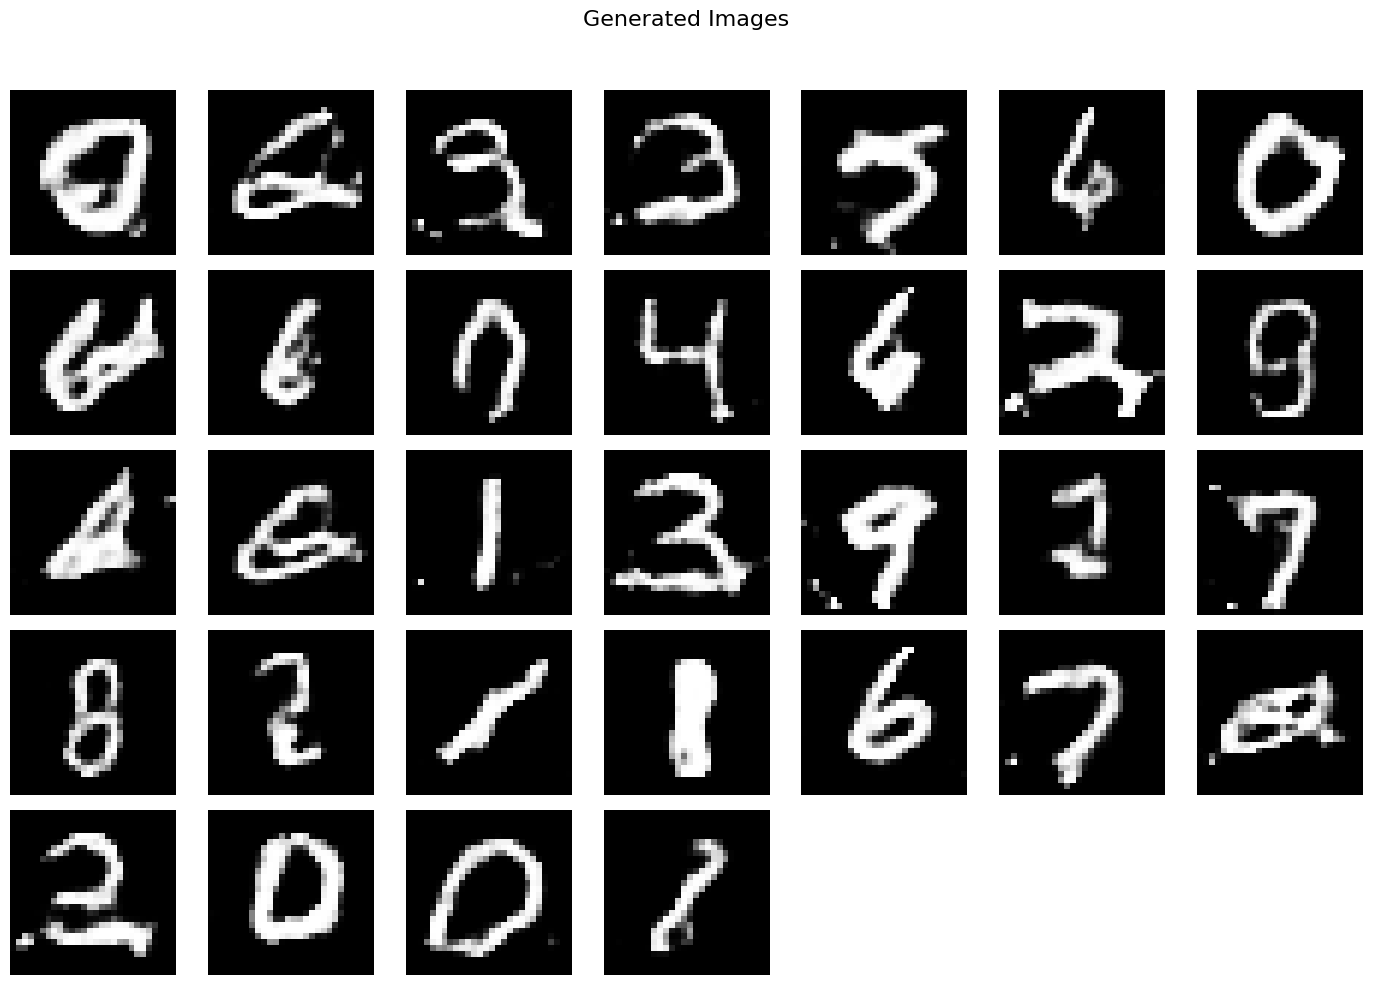

Checkpoint saved at models/checkpoint_epoch_8.pt
Epoch 8: G Loss: 0.727295, D Loss: 0.702113


Epoch 9/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.72it/s]


Image saved to images/output_8.png


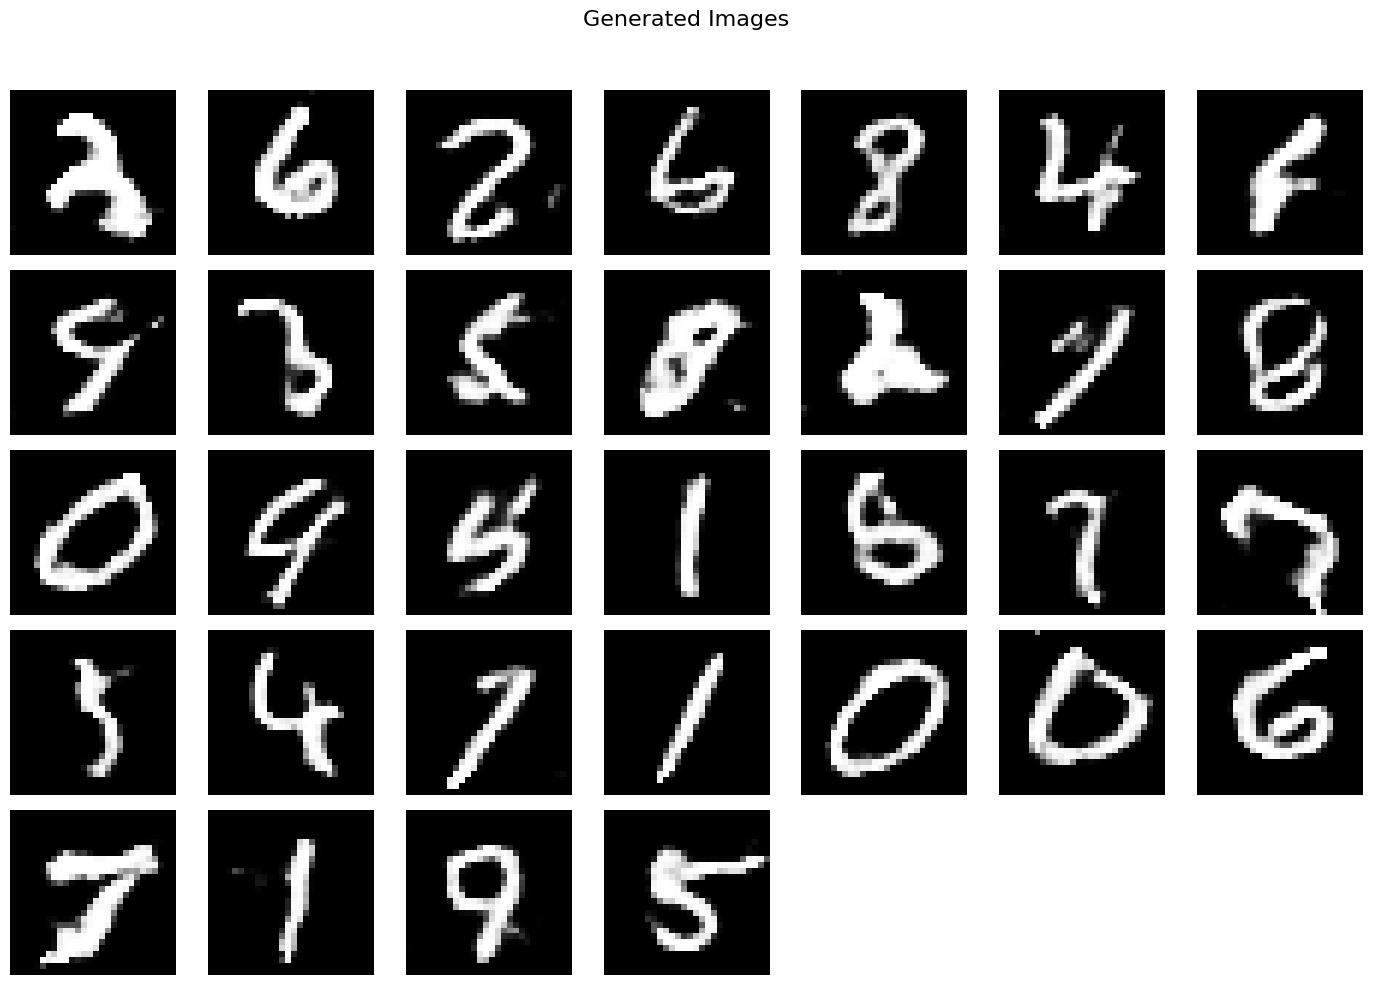

Checkpoint saved at models/checkpoint_epoch_9.pt
Epoch 9: G Loss: 0.727059, D Loss: 0.700768


Epoch 10/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.57it/s]


Image saved to images/output_9.png


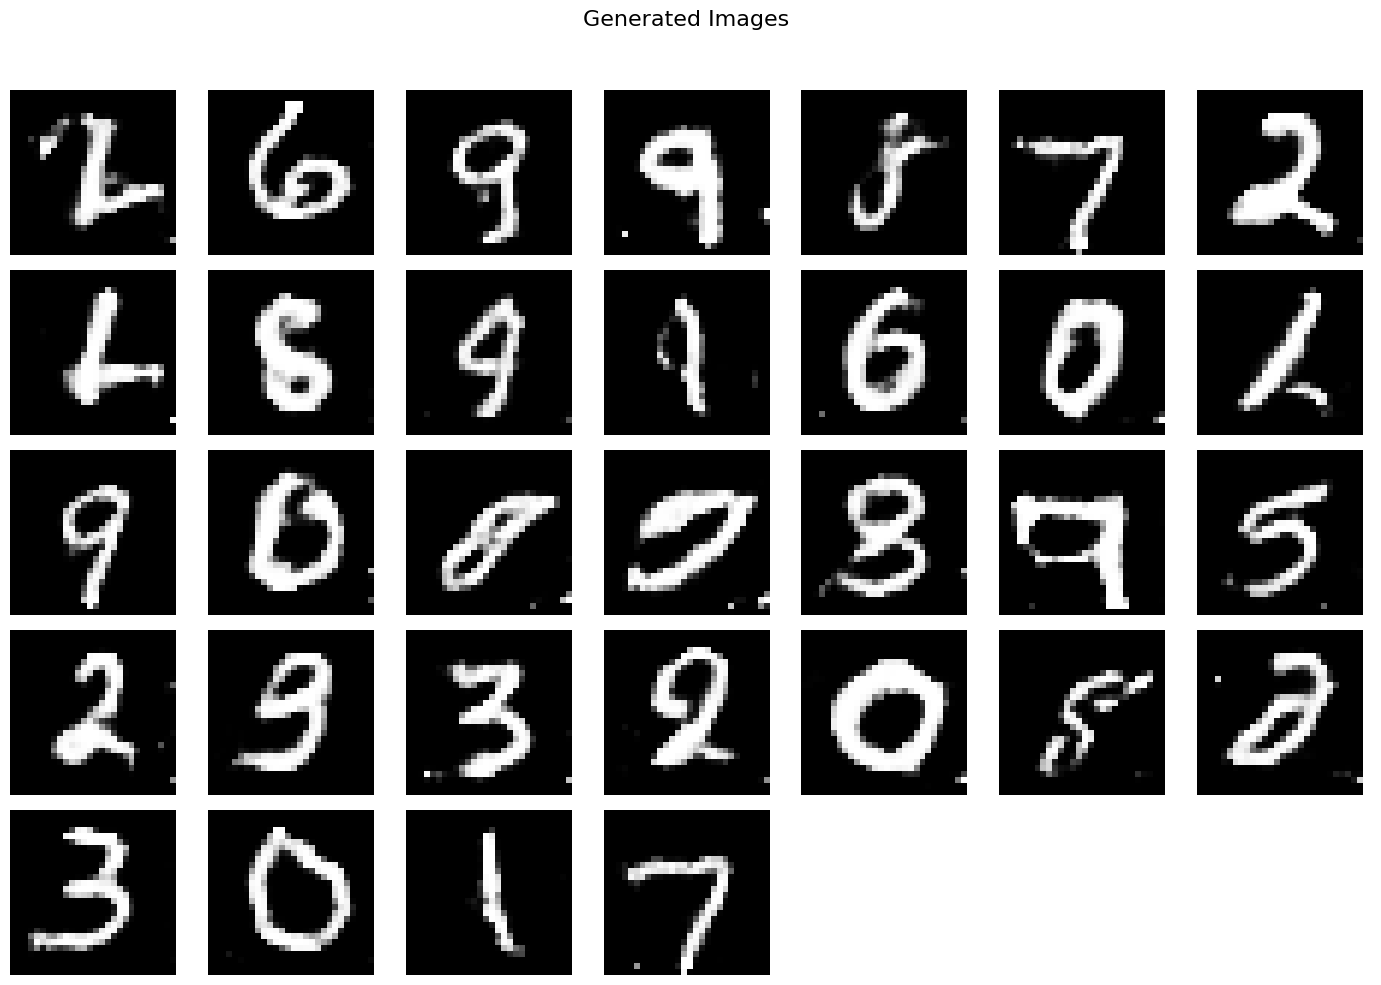

Checkpoint saved at models/checkpoint_epoch_10.pt
Epoch 10: G Loss: 0.725623, D Loss: 0.700778


Epoch 11/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.52it/s]


Image saved to images/output_10.png


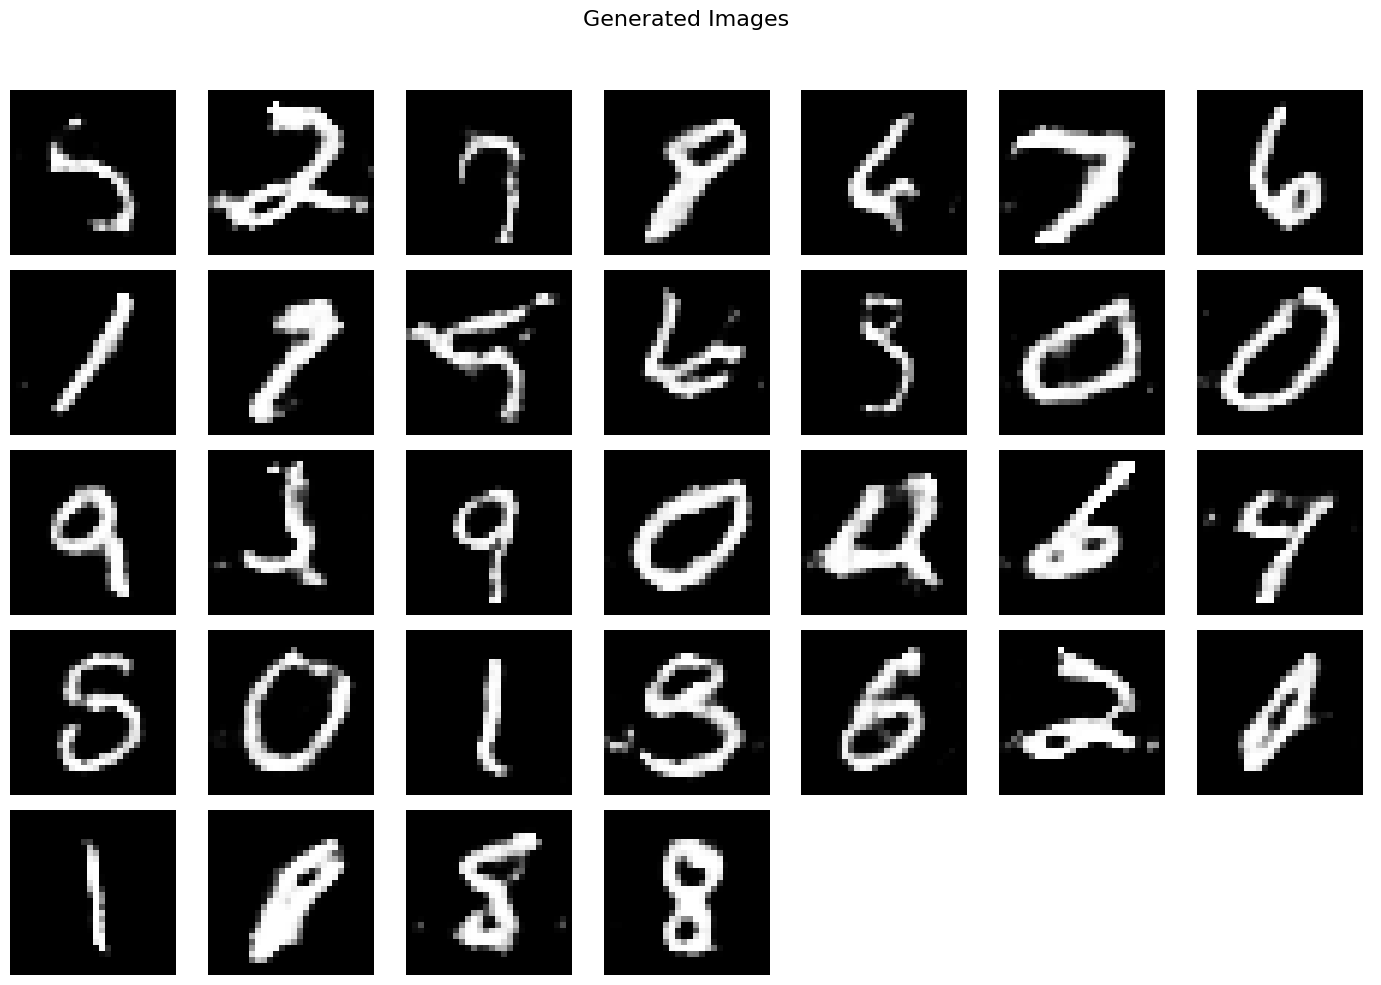

Checkpoint saved at models/checkpoint_epoch_11.pt
Epoch 11: G Loss: 0.723705, D Loss: 0.700099


Epoch 12/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.75it/s]


Image saved to images/output_11.png


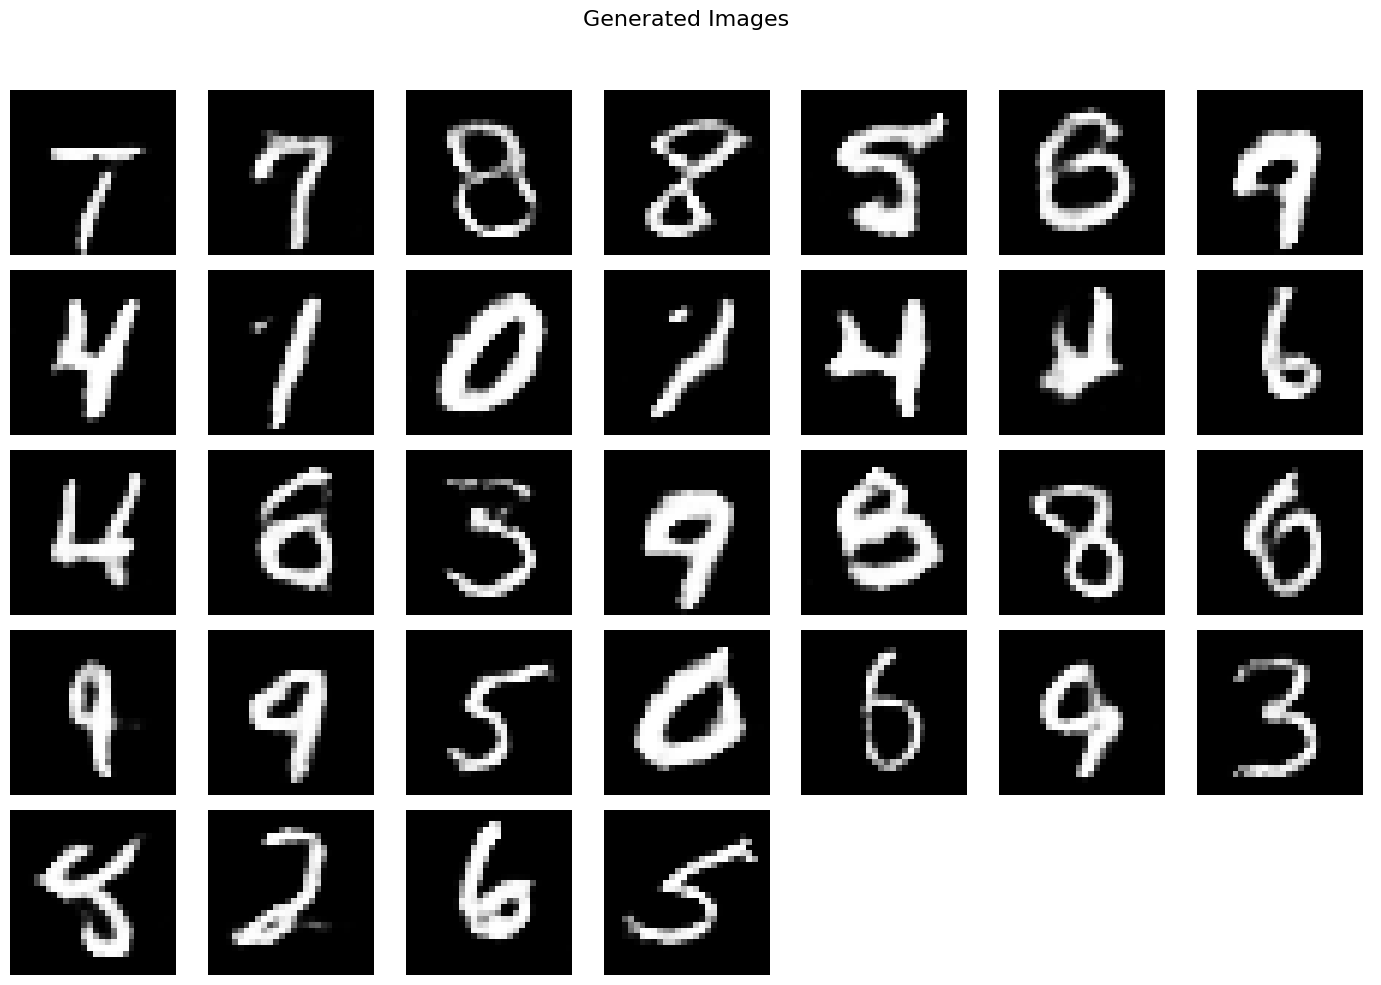

Checkpoint saved at models/checkpoint_epoch_12.pt
Epoch 12: G Loss: 0.723035, D Loss: 0.698904


Epoch 13/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.03it/s]


Image saved to images/output_12.png


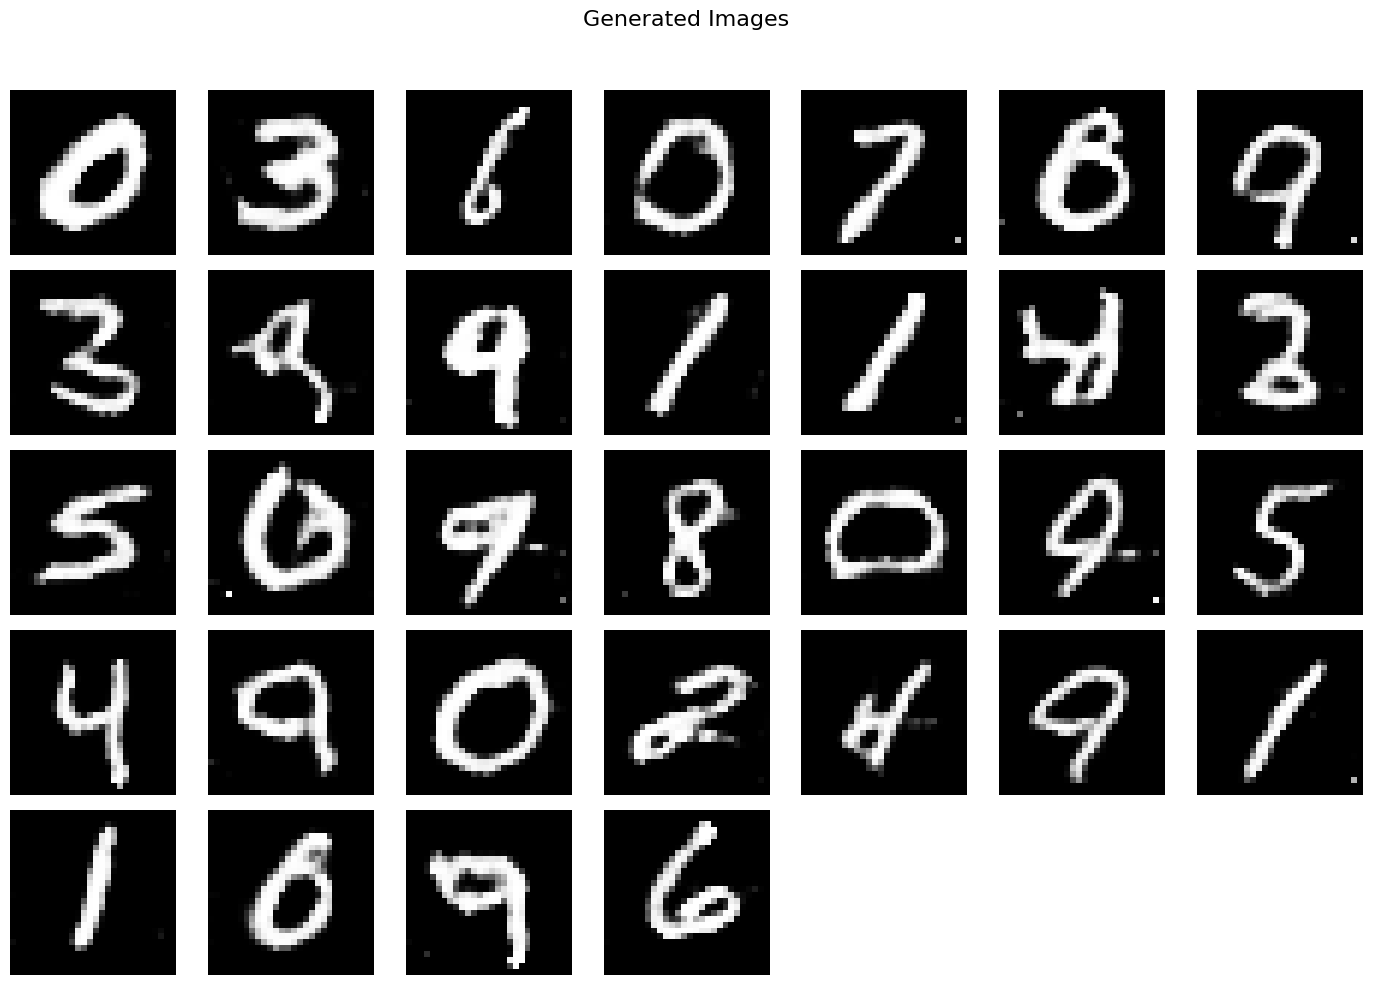

Checkpoint saved at models/checkpoint_epoch_13.pt
Epoch 13: G Loss: 0.724398, D Loss: 0.698863


Epoch 14/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.54it/s]


Image saved to images/output_13.png


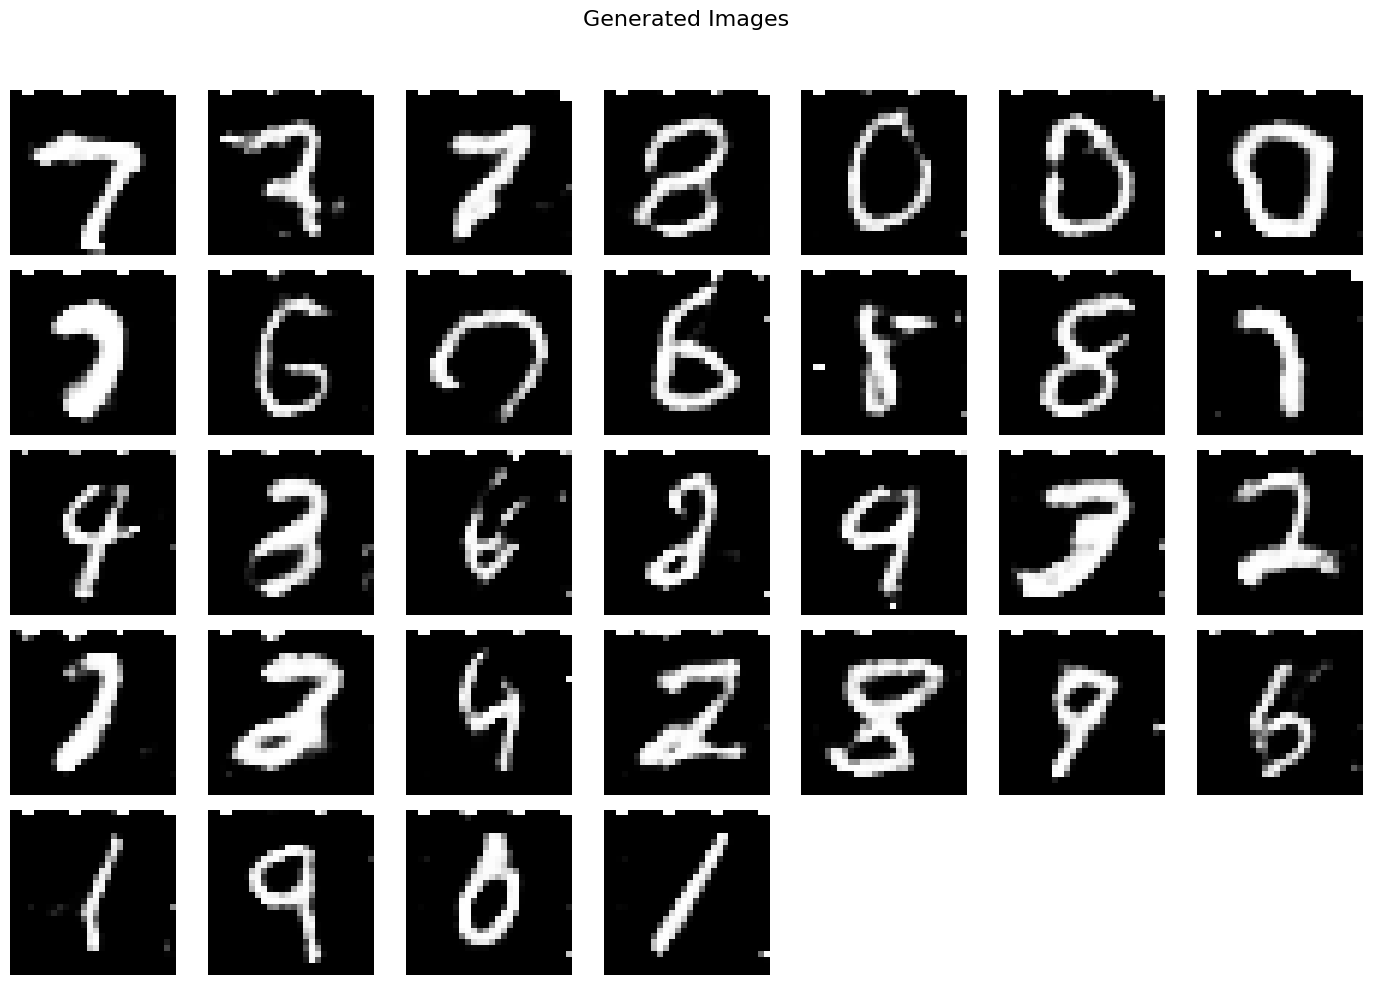

Checkpoint saved at models/checkpoint_epoch_14.pt
Epoch 14: G Loss: 0.721933, D Loss: 0.700391


Epoch 15/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.69it/s]


Image saved to images/output_14.png


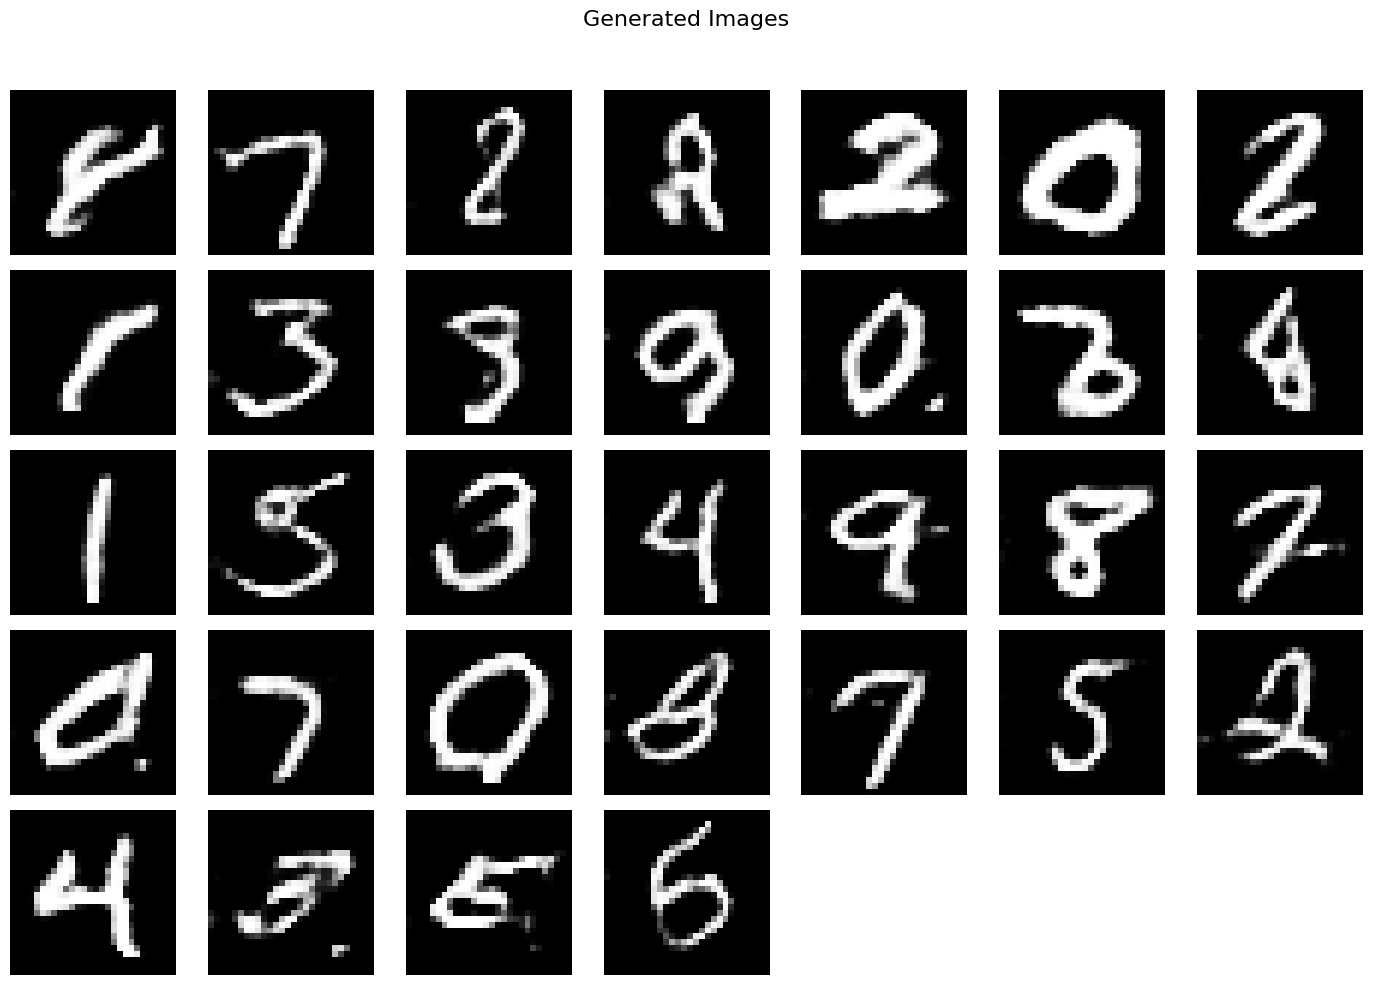

Checkpoint saved at models/checkpoint_epoch_15.pt
Epoch 15: G Loss: 0.721873, D Loss: 0.697455


Epoch 16/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.44it/s]


Image saved to images/output_15.png


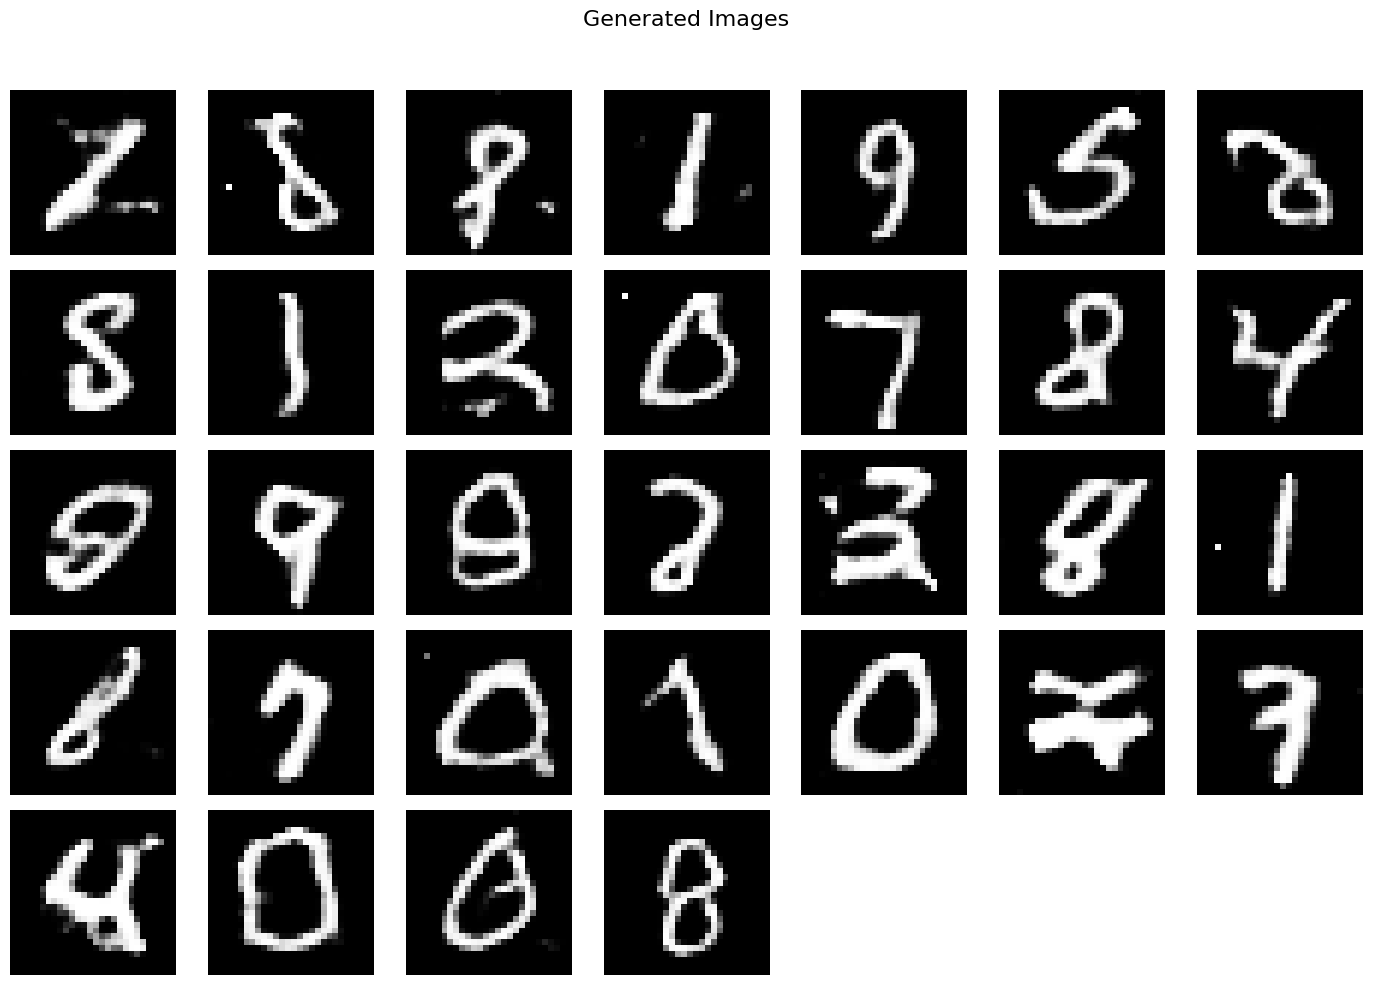

Checkpoint saved at models/checkpoint_epoch_16.pt
Epoch 16: G Loss: 0.721994, D Loss: 0.697308


Epoch 17/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.00it/s]


Image saved to images/output_16.png


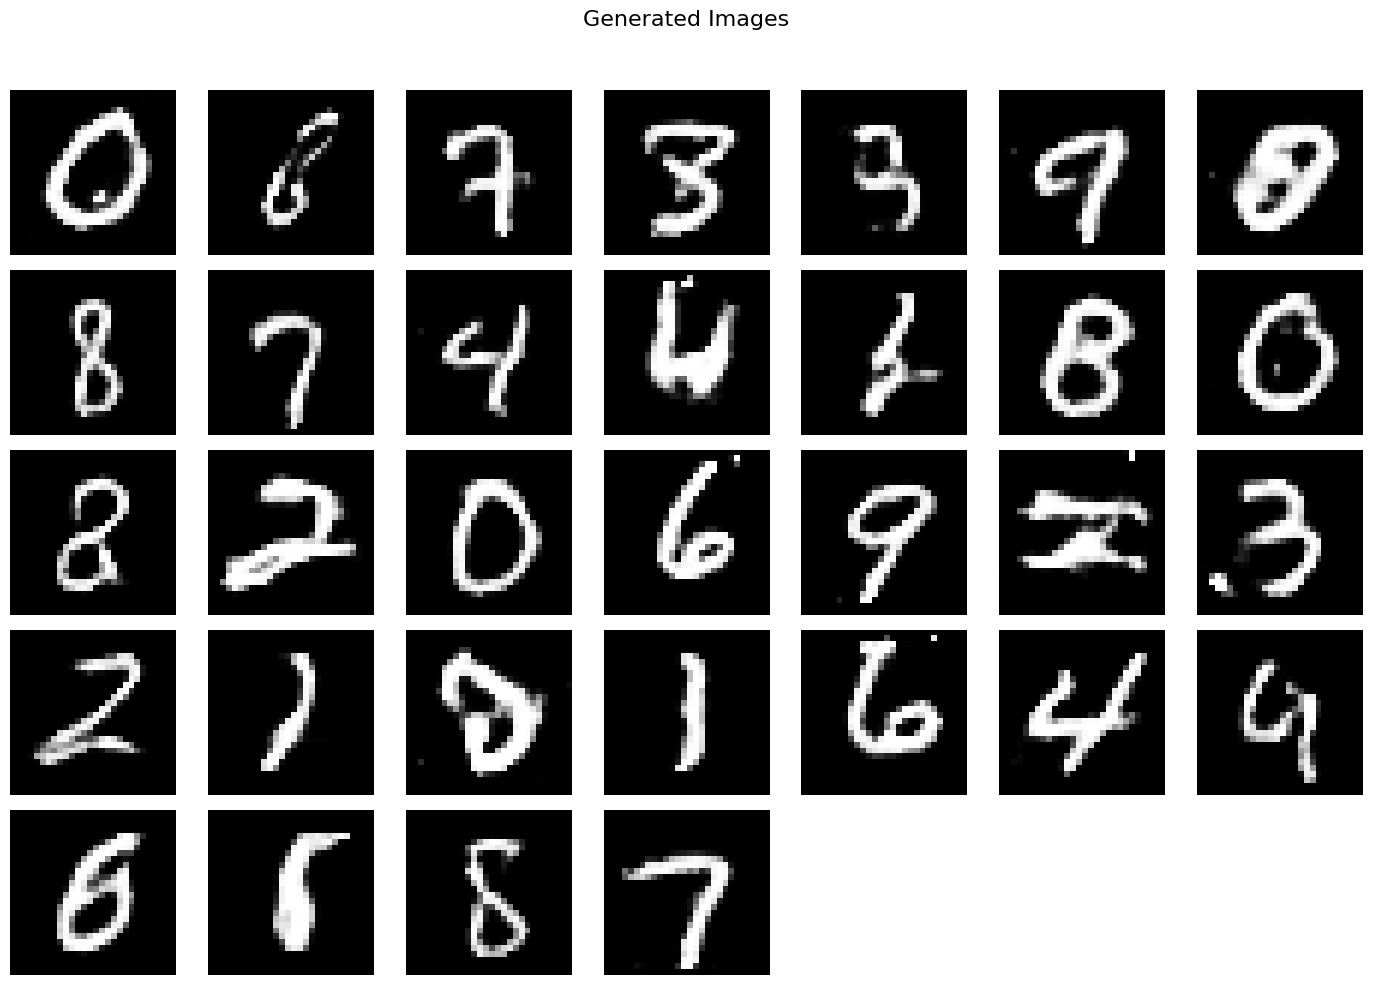

Checkpoint saved at models/checkpoint_epoch_17.pt
Epoch 17: G Loss: 0.724069, D Loss: 0.698940


Epoch 18/50: 100%|██████████| 1875/1875 [00:58<00:00, 31.94it/s]


Image saved to images/output_17.png


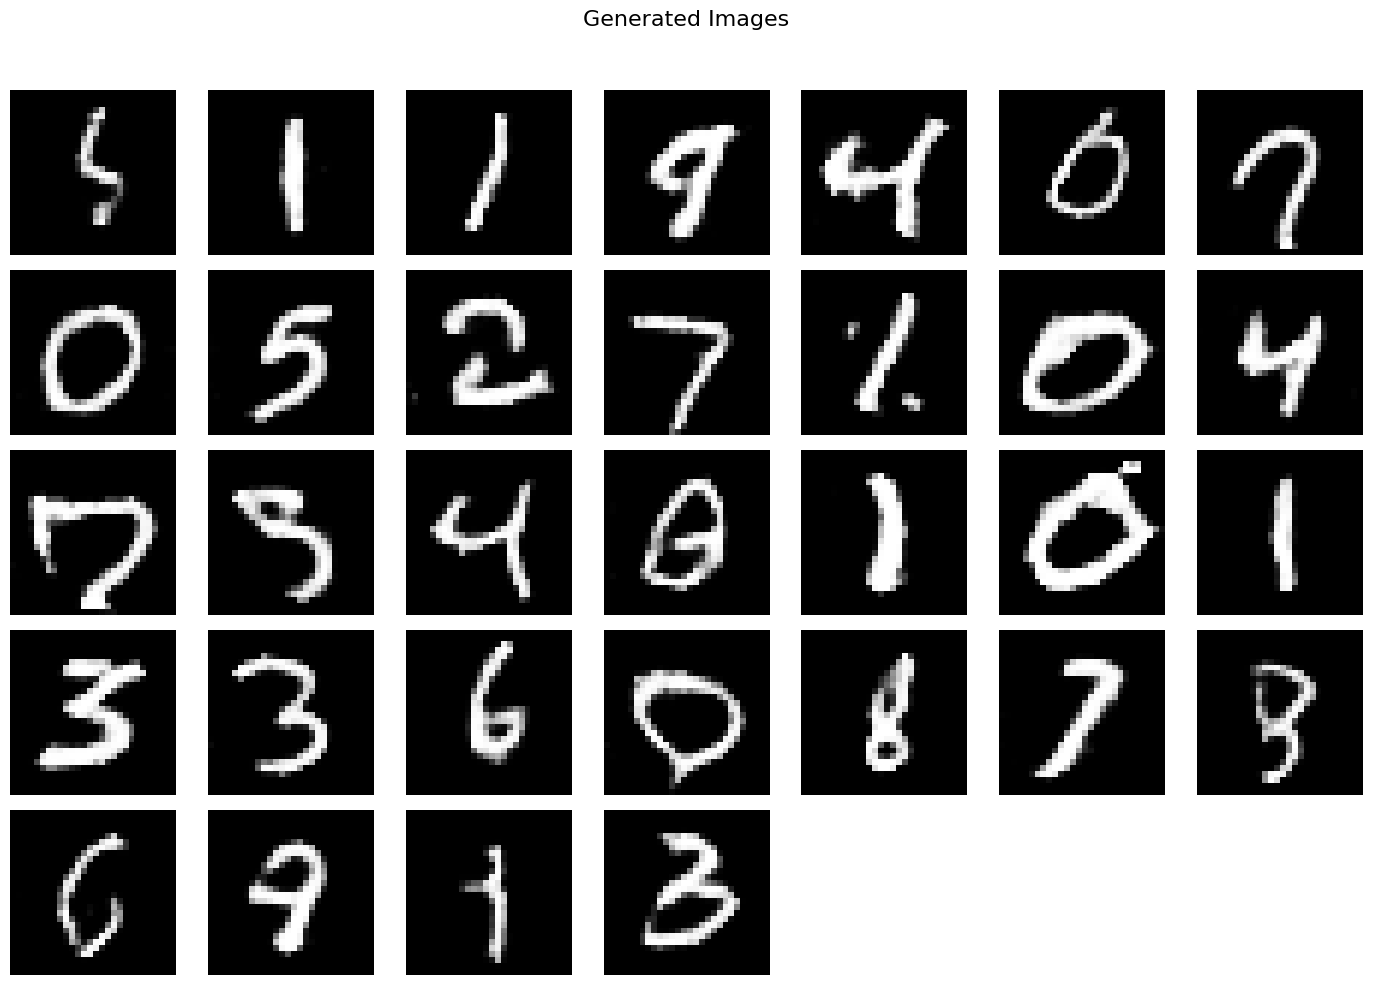

Checkpoint saved at models/checkpoint_epoch_18.pt
Epoch 18: G Loss: 0.723099, D Loss: 0.695308


Epoch 19/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.10it/s]


Image saved to images/output_18.png


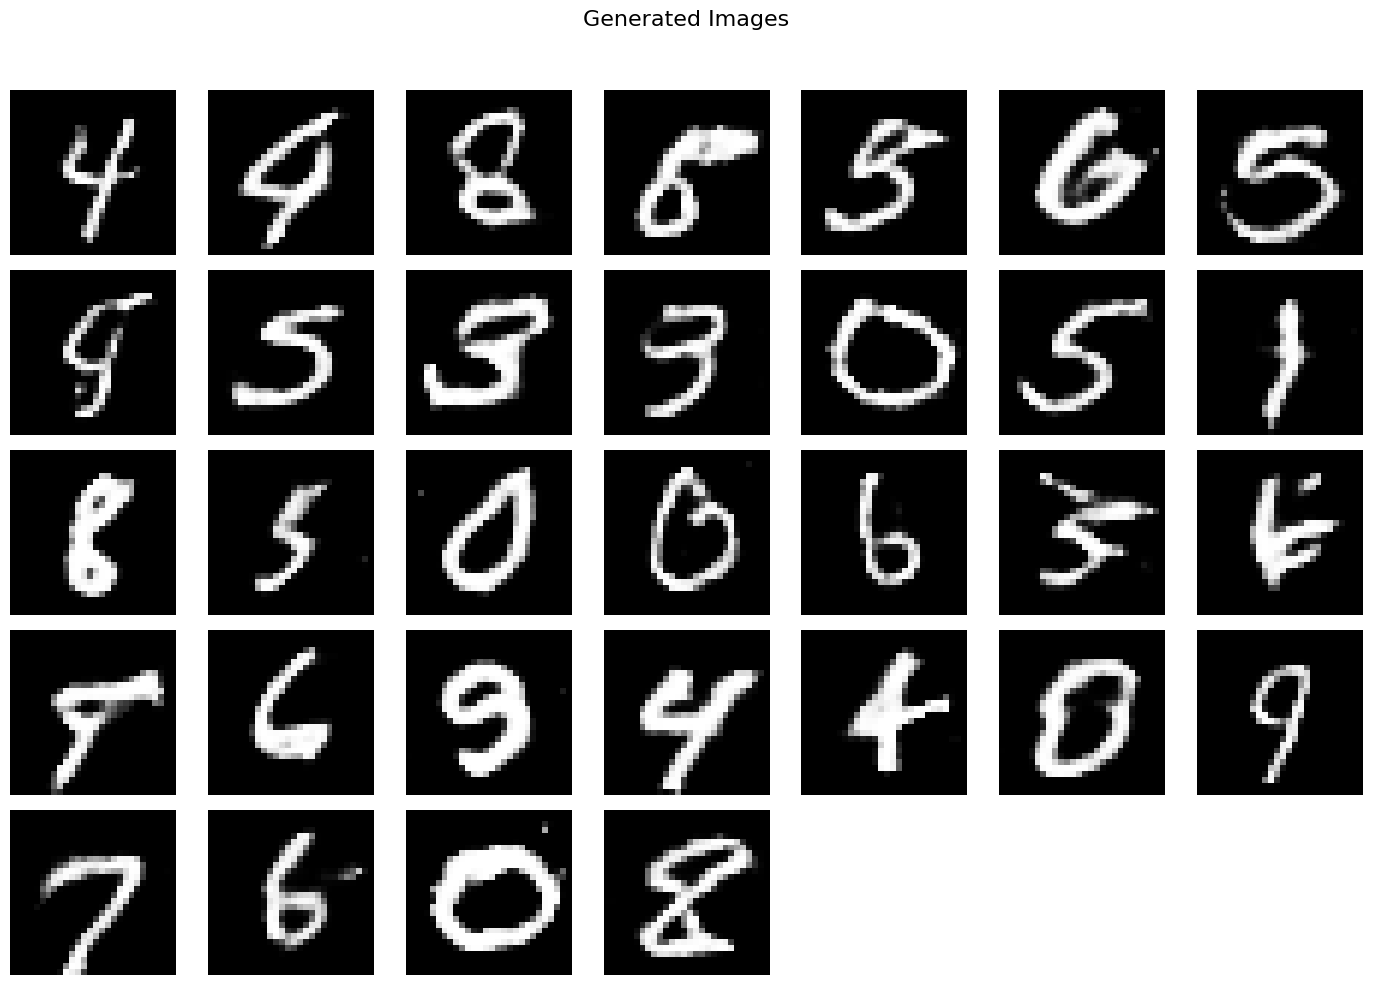

Checkpoint saved at models/checkpoint_epoch_19.pt
Epoch 19: G Loss: 0.723019, D Loss: 0.696660


Epoch 20/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.28it/s]


Image saved to images/output_19.png


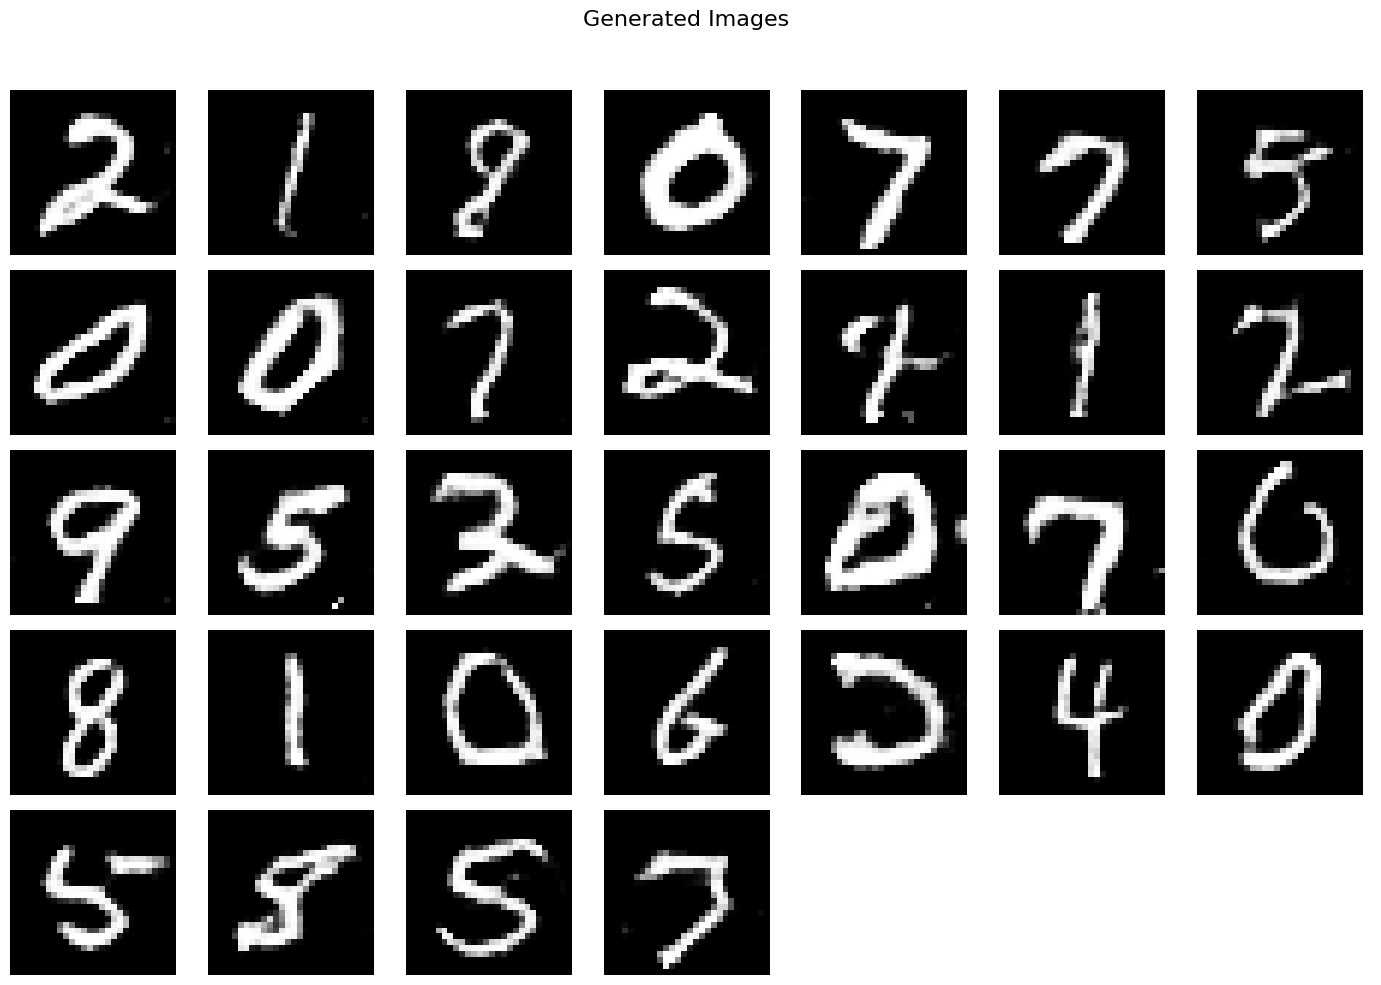

Checkpoint saved at models/checkpoint_epoch_20.pt
Epoch 20: G Loss: 0.724374, D Loss: 0.696707


Epoch 21/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.86it/s]


Image saved to images/output_20.png


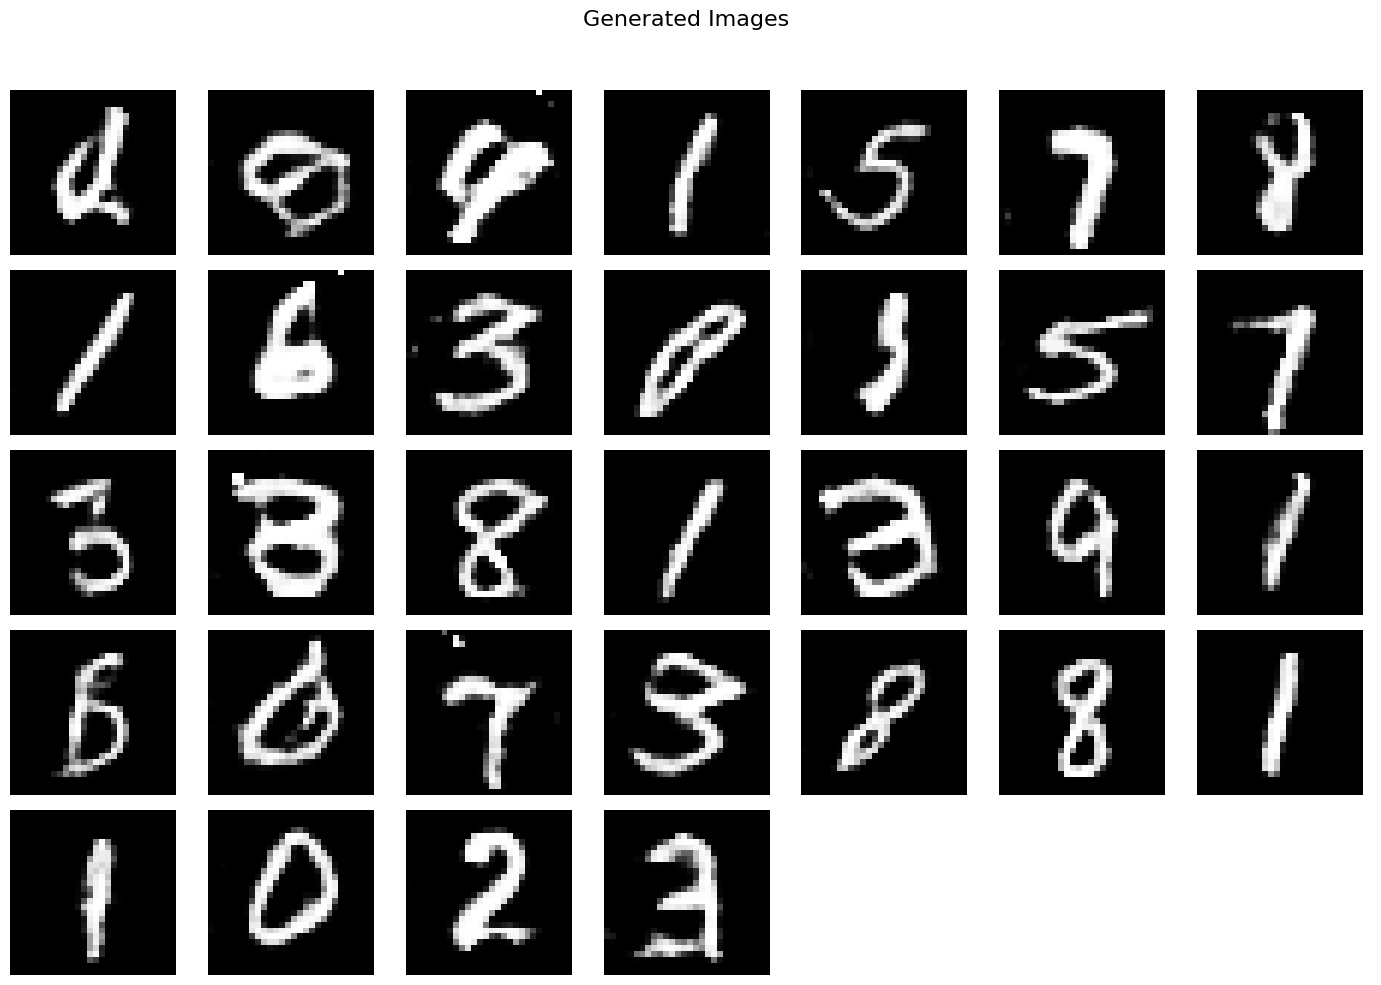

Checkpoint saved at models/checkpoint_epoch_21.pt
Epoch 21: G Loss: 0.724727, D Loss: 0.695568


Epoch 22/50: 100%|██████████| 1875/1875 [00:57<00:00, 32.65it/s]


Image saved to images/output_21.png


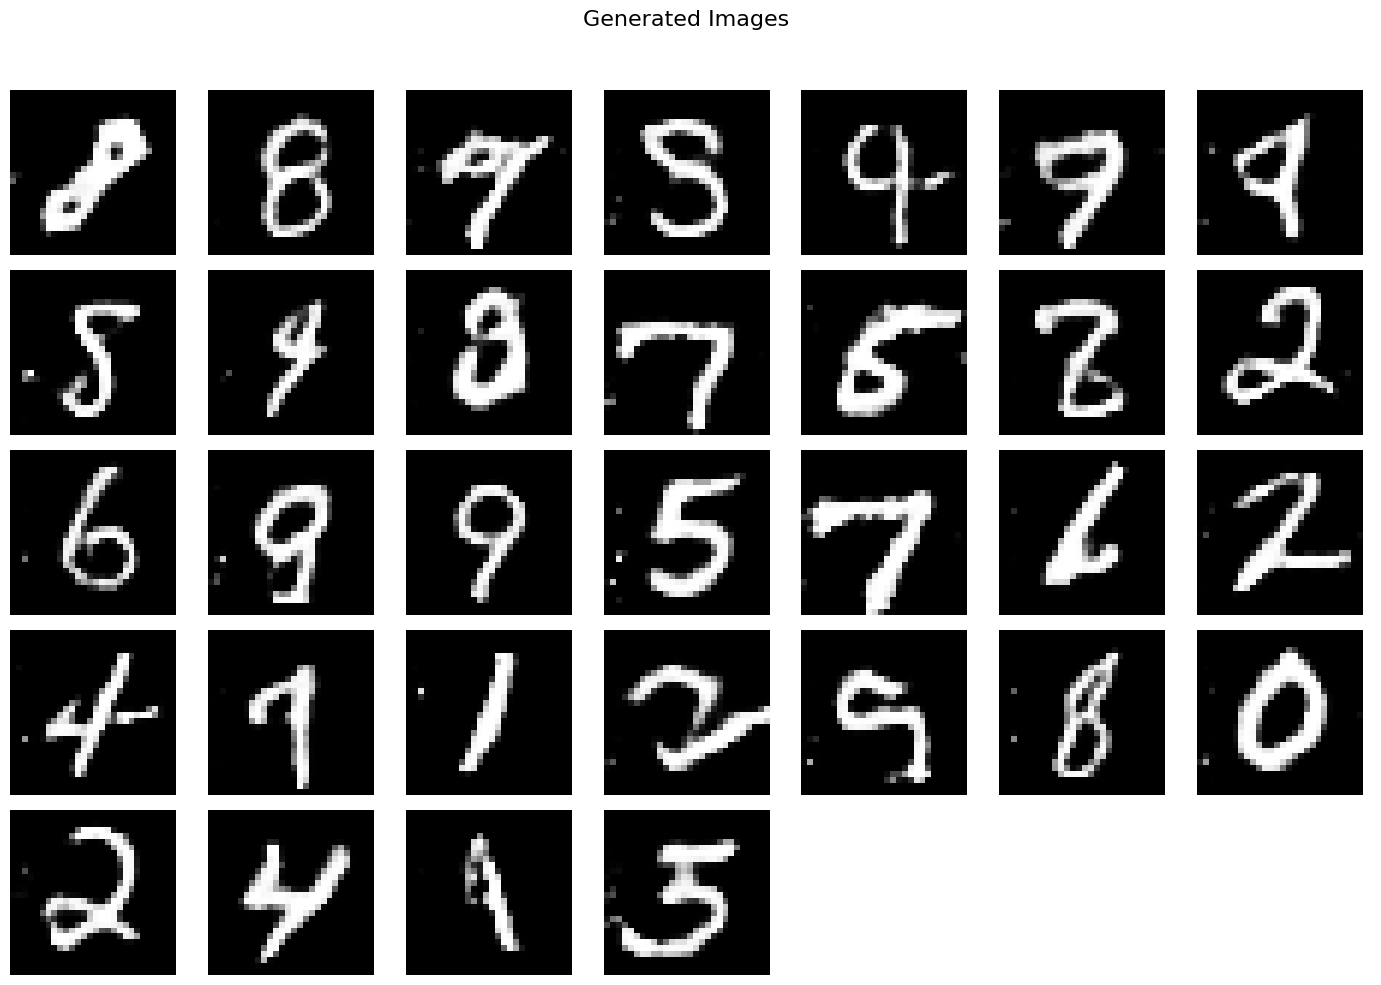

Checkpoint saved at models/checkpoint_epoch_22.pt
Epoch 22: G Loss: 0.726870, D Loss: 0.692989


Epoch 23/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.31it/s]


Image saved to images/output_22.png


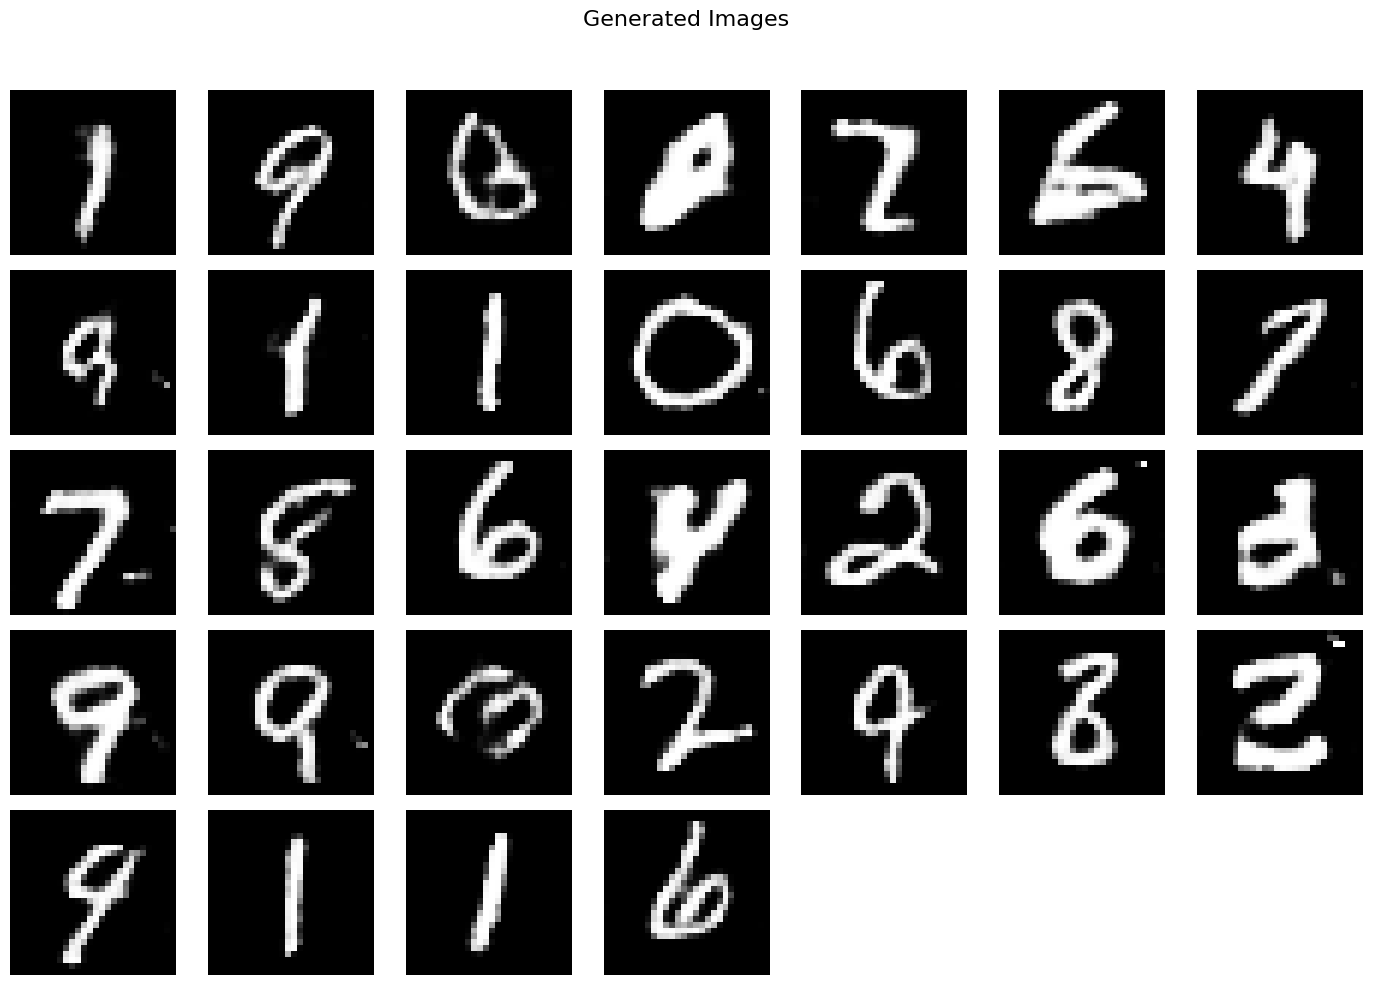

Checkpoint saved at models/checkpoint_epoch_23.pt
Epoch 23: G Loss: 0.728152, D Loss: 0.692871


Epoch 24/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.05it/s]


Image saved to images/output_23.png


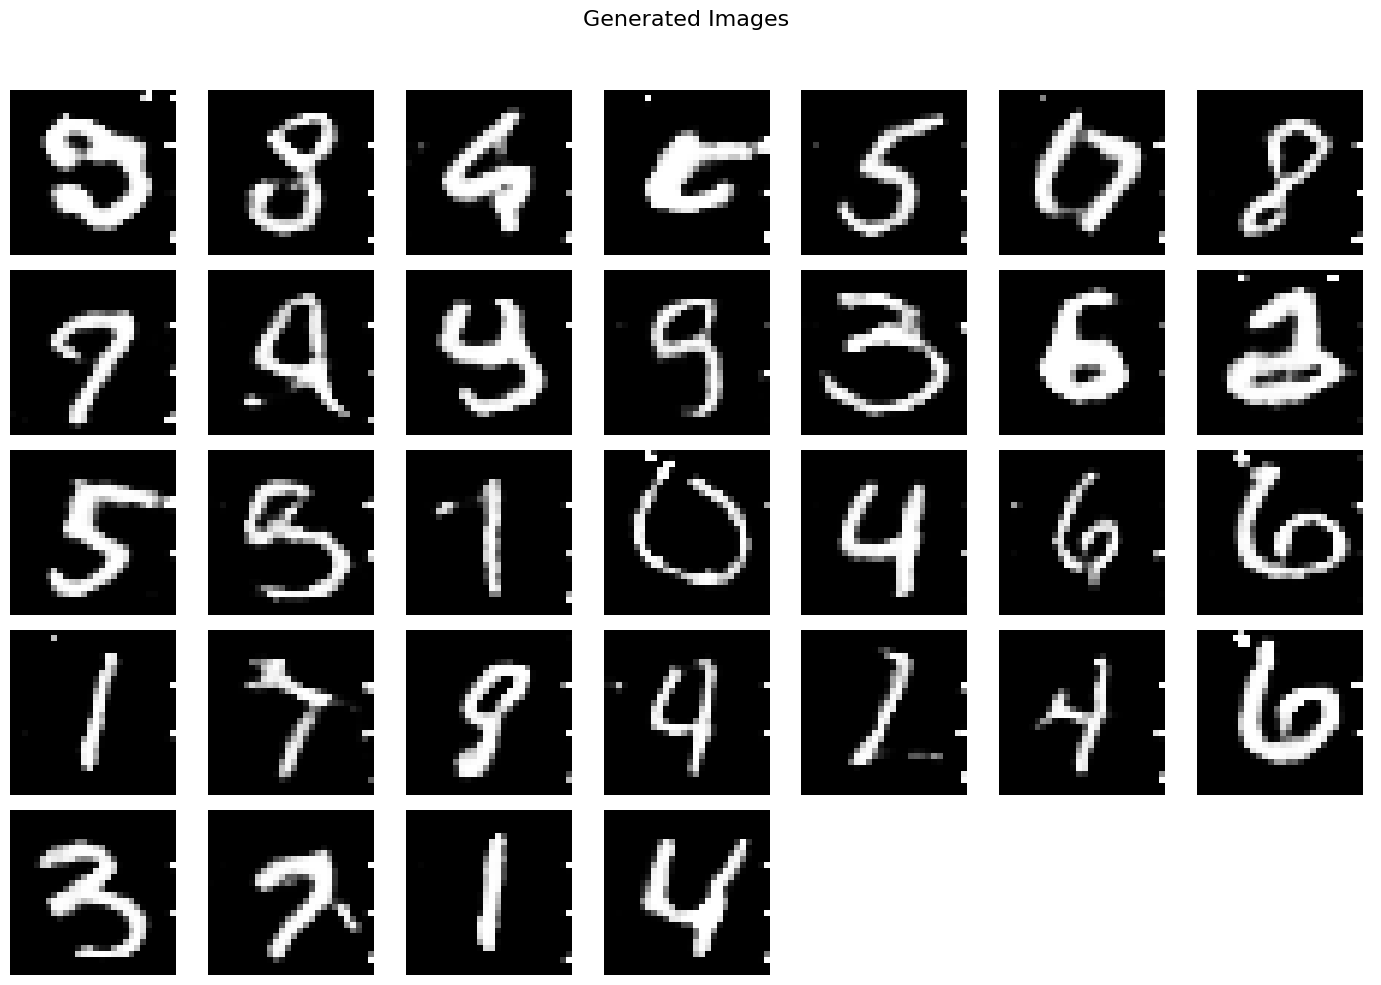

Checkpoint saved at models/checkpoint_epoch_24.pt
Epoch 24: G Loss: 0.727019, D Loss: 0.694711


Epoch 25/50: 100%|██████████| 1875/1875 [00:58<00:00, 31.90it/s]


Image saved to images/output_24.png


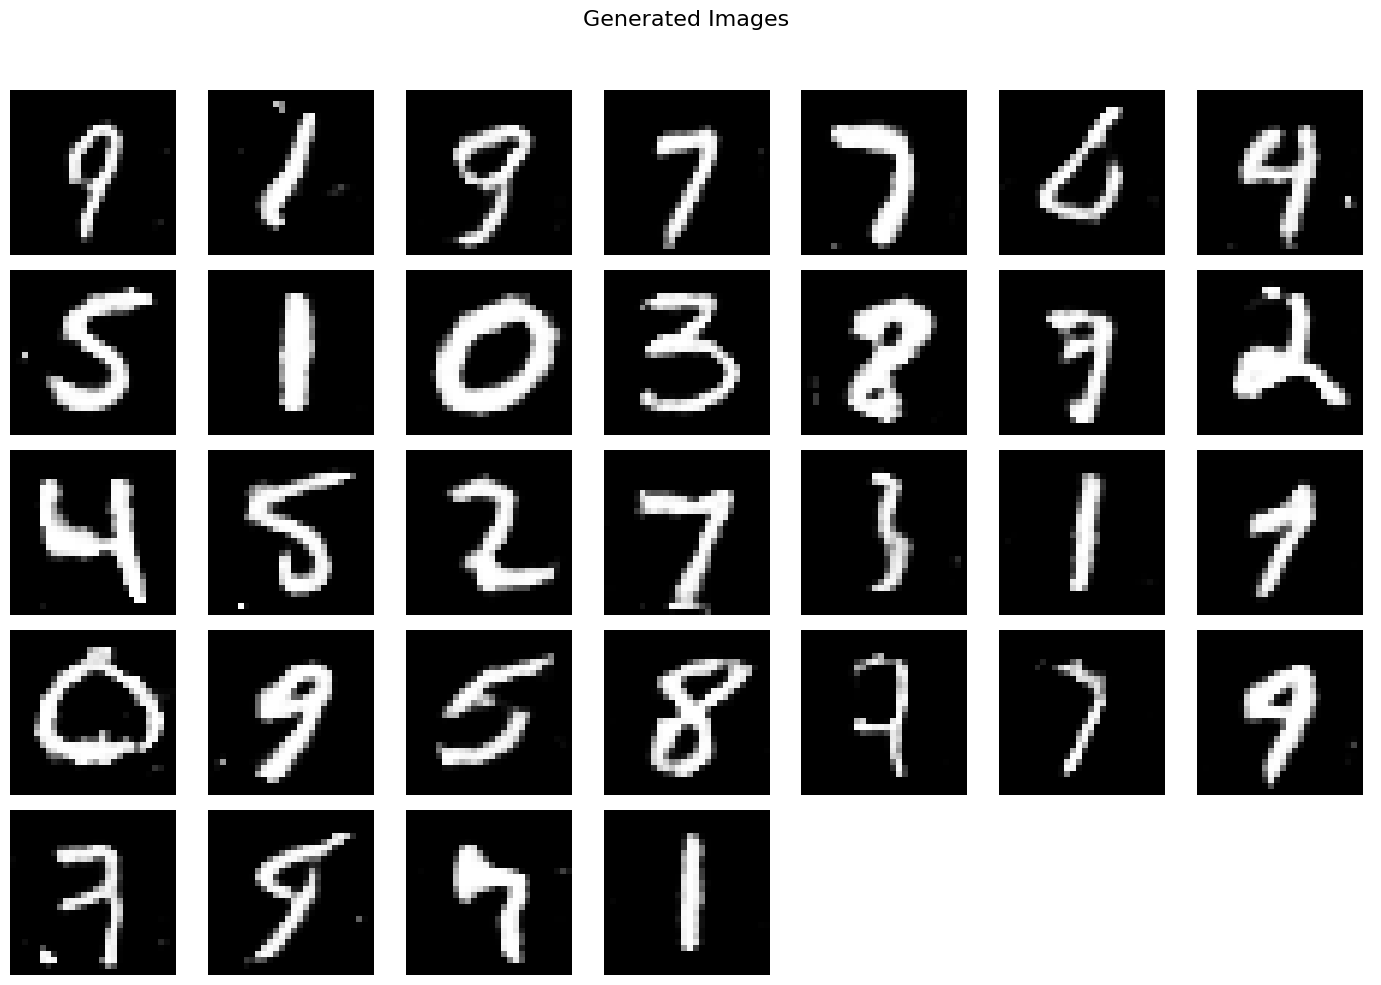

Checkpoint saved at models/checkpoint_epoch_25.pt
Epoch 25: G Loss: 0.728658, D Loss: 0.690411


Epoch 26/50: 100%|██████████| 1875/1875 [00:58<00:00, 31.85it/s]


Image saved to images/output_25.png


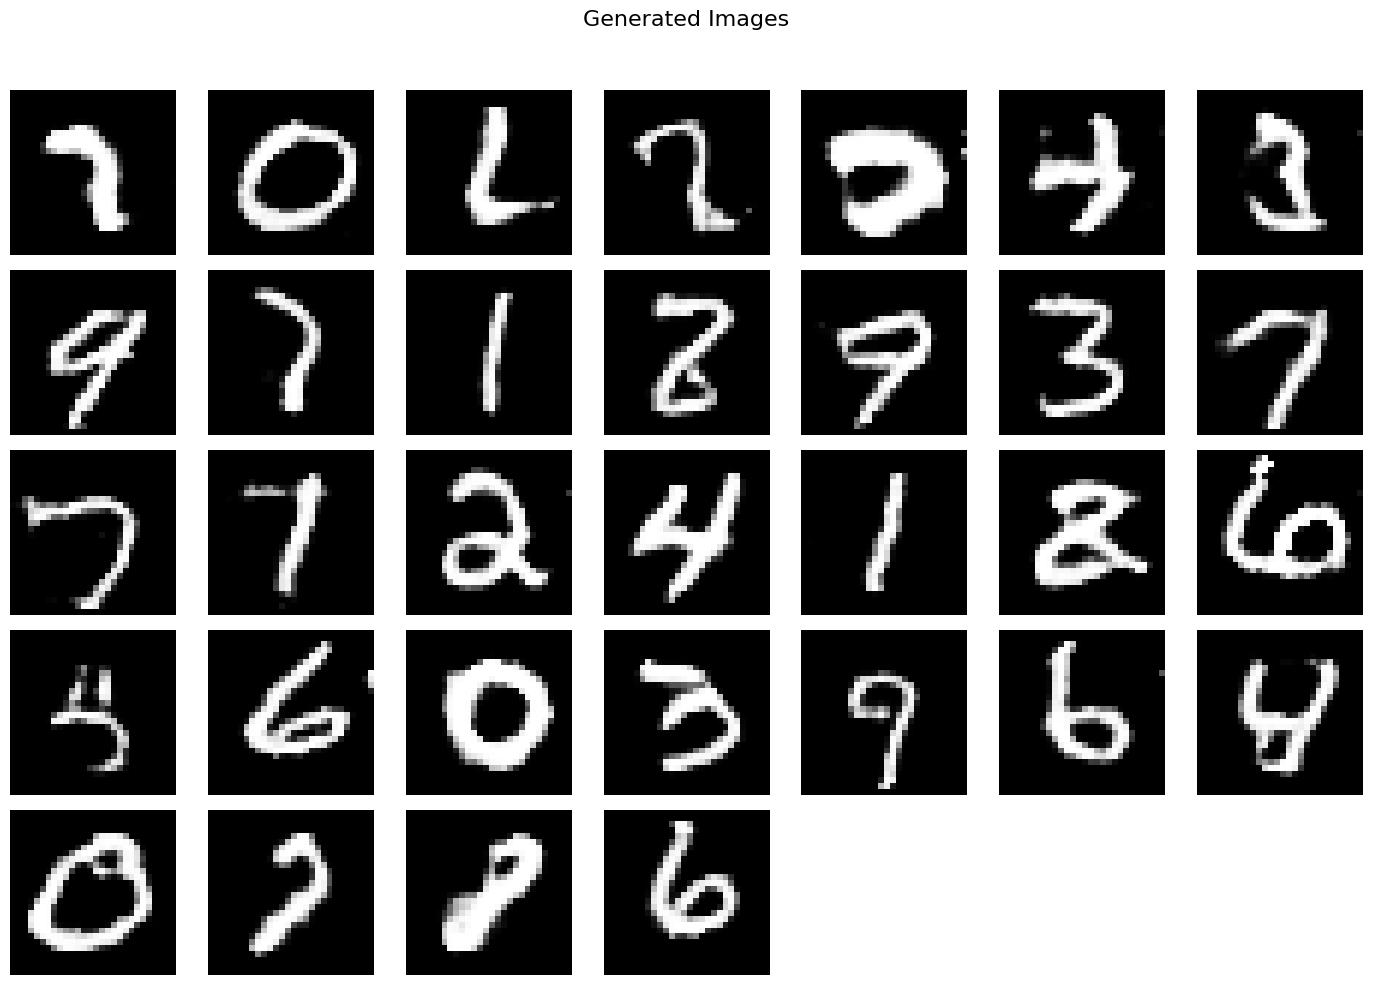

Checkpoint saved at models/checkpoint_epoch_26.pt
Epoch 26: G Loss: 0.729275, D Loss: 0.691572


Epoch 27/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.19it/s]


Image saved to images/output_26.png


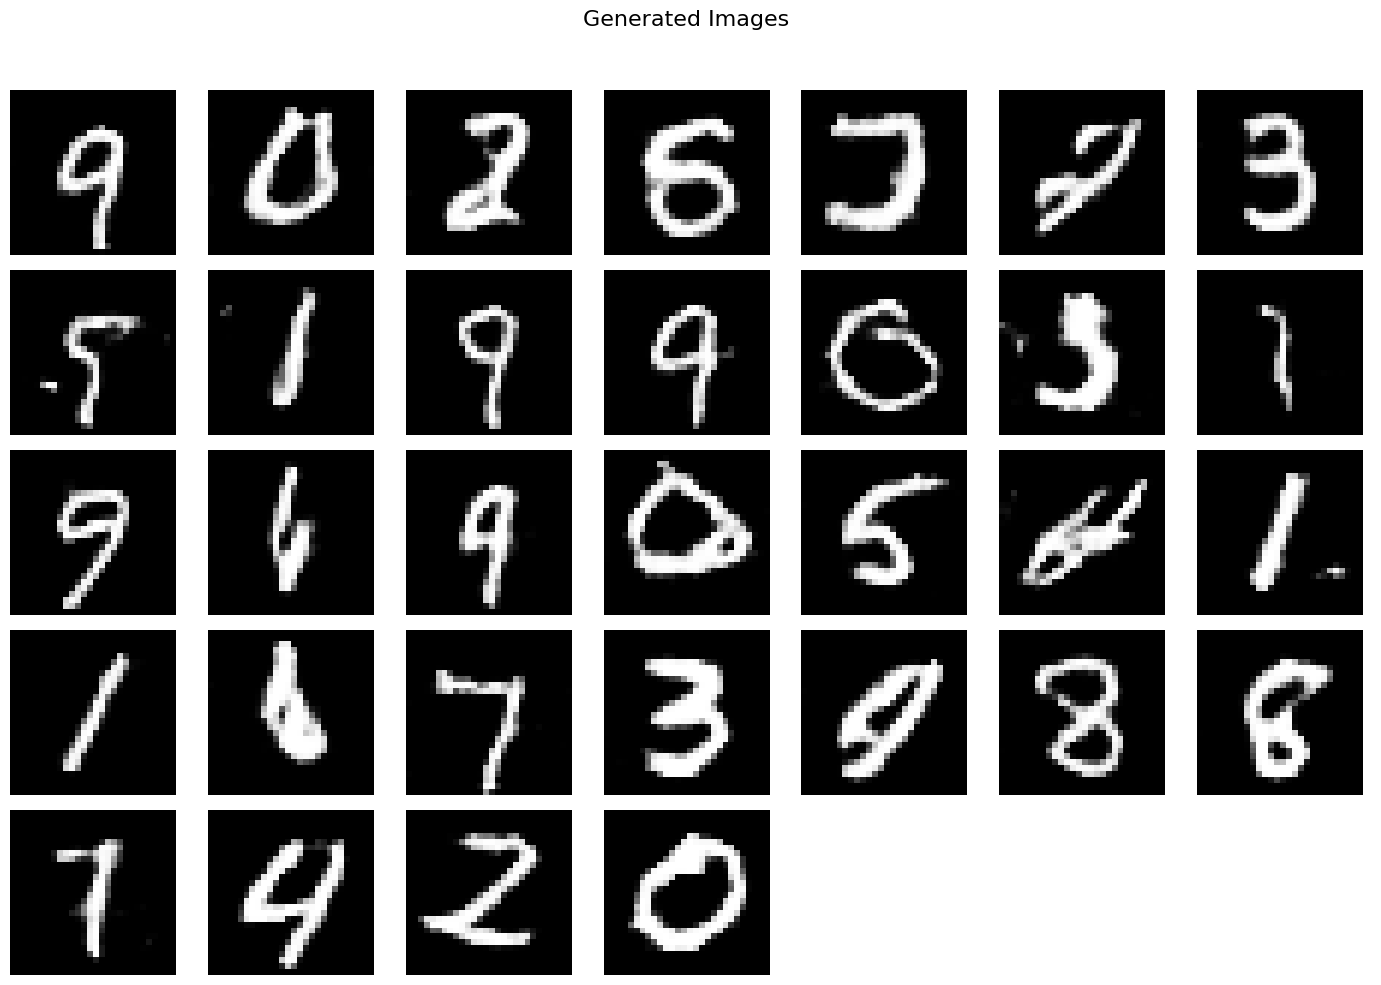

Checkpoint saved at models/checkpoint_epoch_27.pt
Epoch 27: G Loss: 0.735839, D Loss: 0.690565


Epoch 28/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.14it/s]


Image saved to images/output_27.png


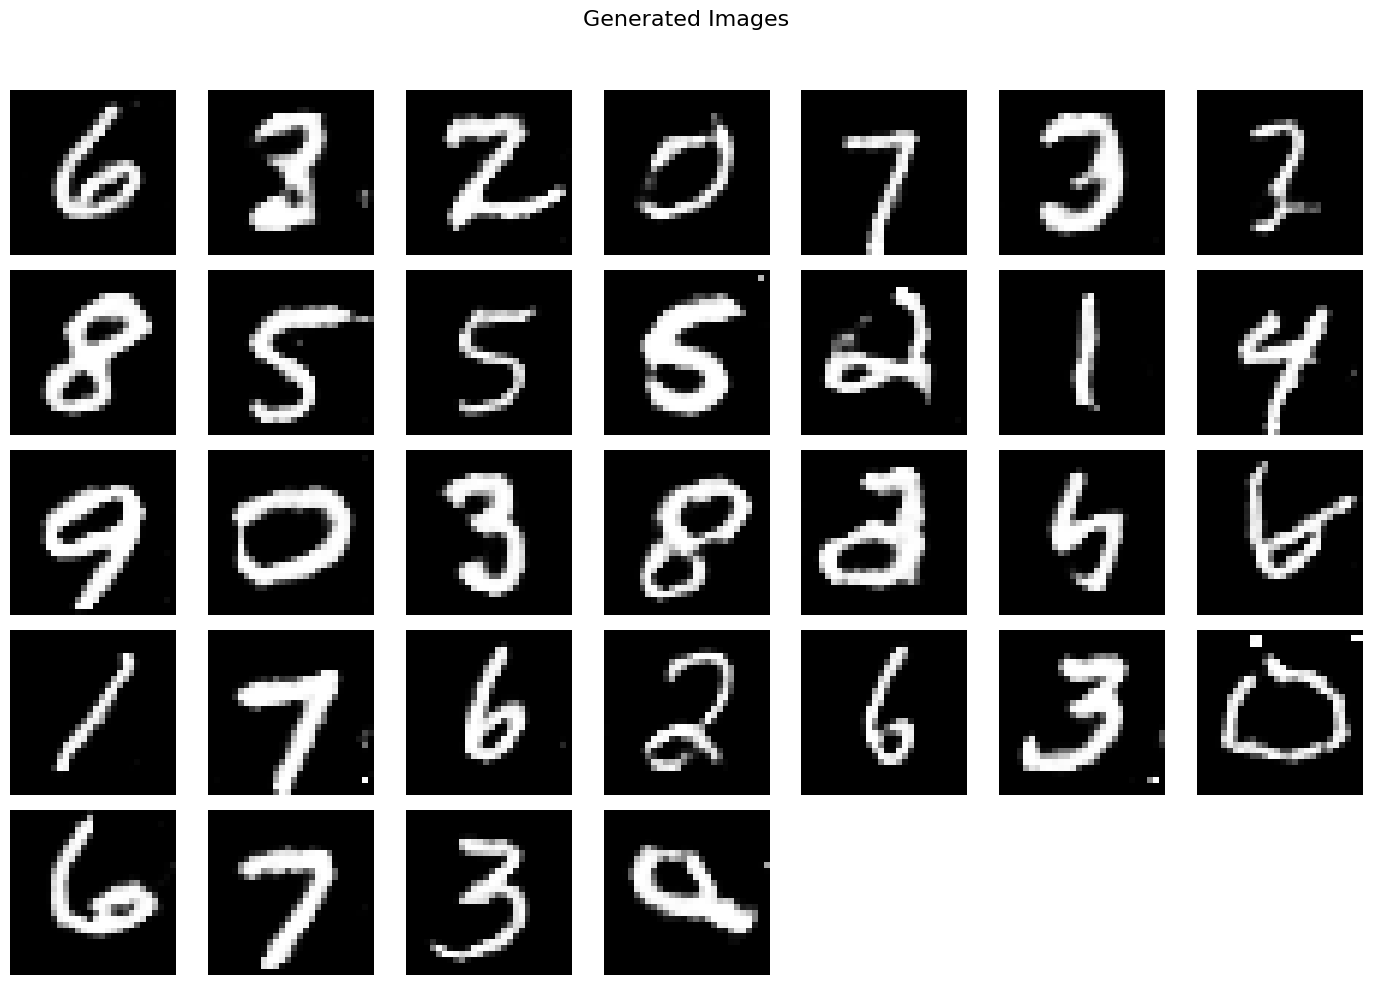

Checkpoint saved at models/checkpoint_epoch_28.pt
Epoch 28: G Loss: 0.738007, D Loss: 0.687956


Epoch 29/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.14it/s]


Image saved to images/output_28.png


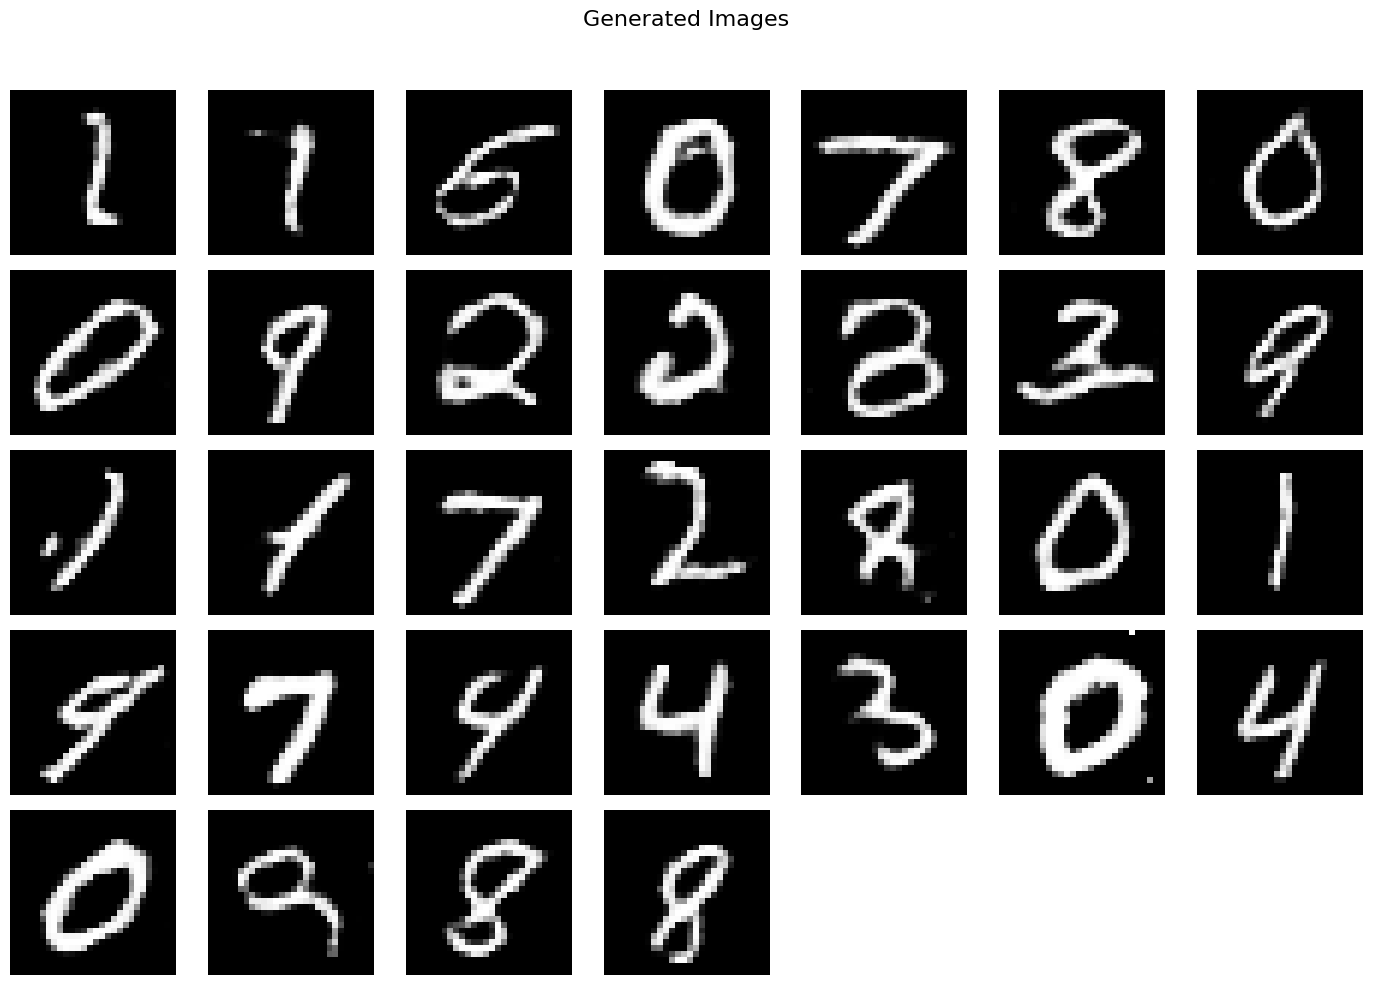

Checkpoint saved at models/checkpoint_epoch_29.pt
Epoch 29: G Loss: 0.741845, D Loss: 0.685517


Epoch 30/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.14it/s]


Image saved to images/output_29.png


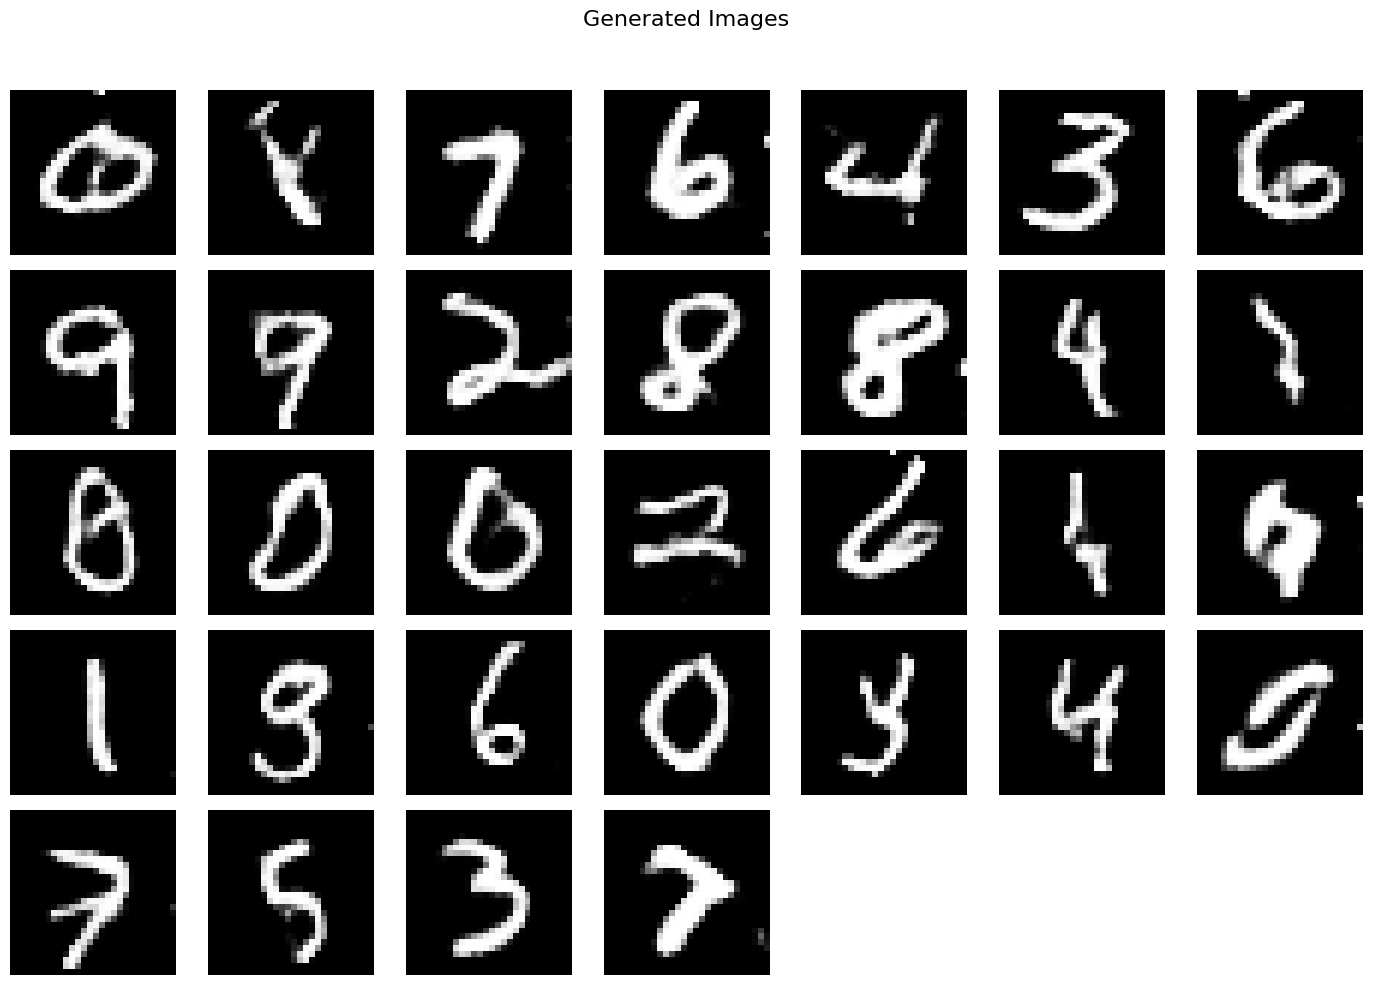

Checkpoint saved at models/checkpoint_epoch_30.pt
Epoch 30: G Loss: 0.746333, D Loss: 0.684978


Epoch 31/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.32it/s]


Image saved to images/output_30.png


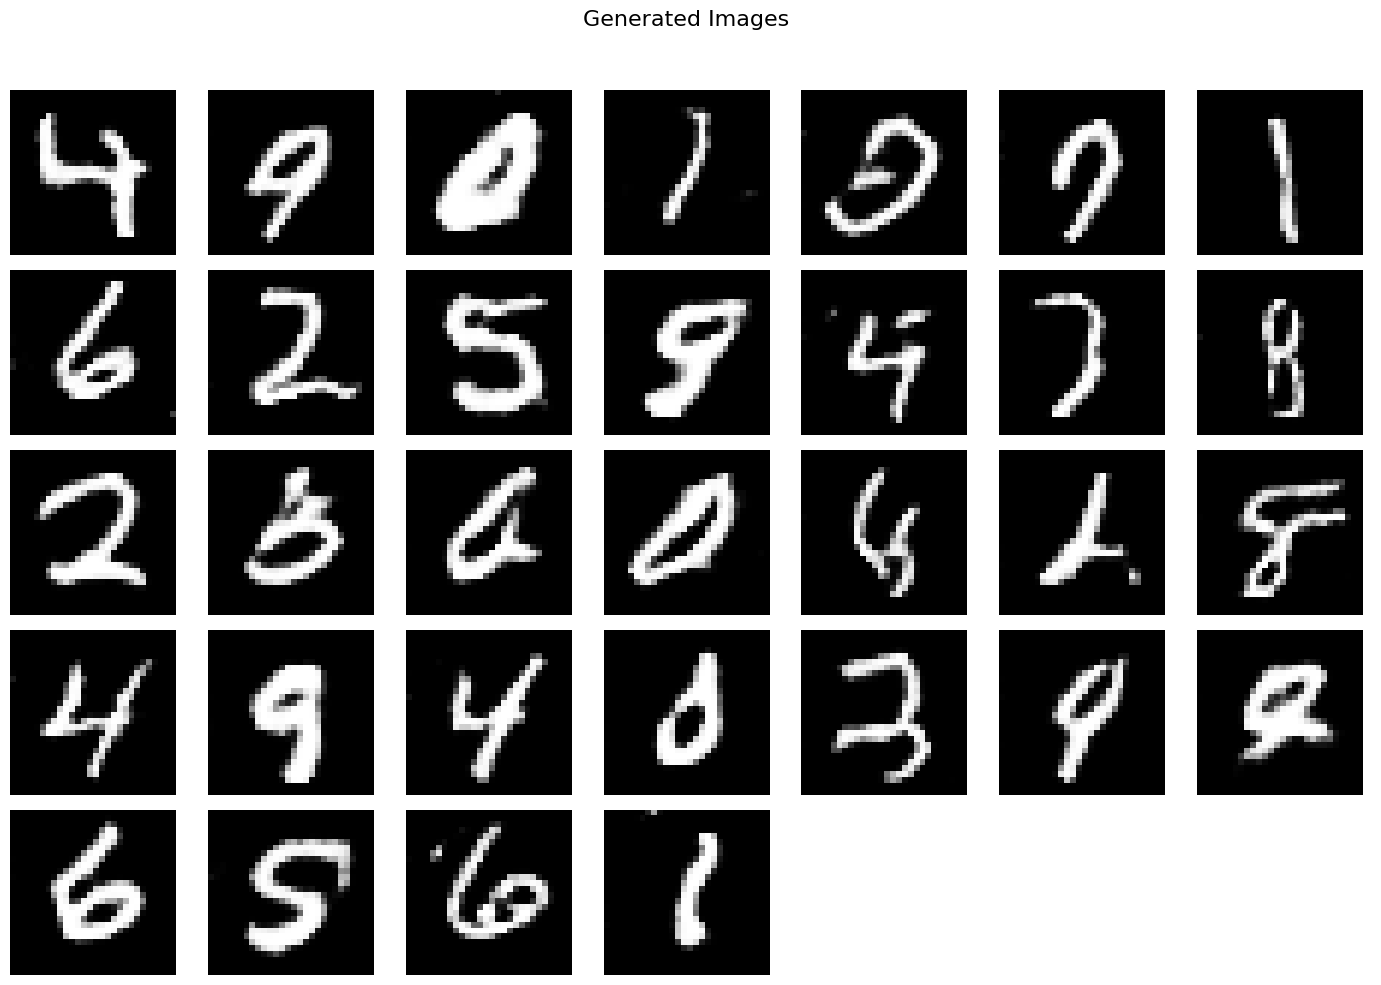

Checkpoint saved at models/checkpoint_epoch_31.pt
Epoch 31: G Loss: 0.754158, D Loss: 0.680381


Epoch 32/50: 100%|██████████| 1875/1875 [00:58<00:00, 32.20it/s]


Image saved to images/output_31.png


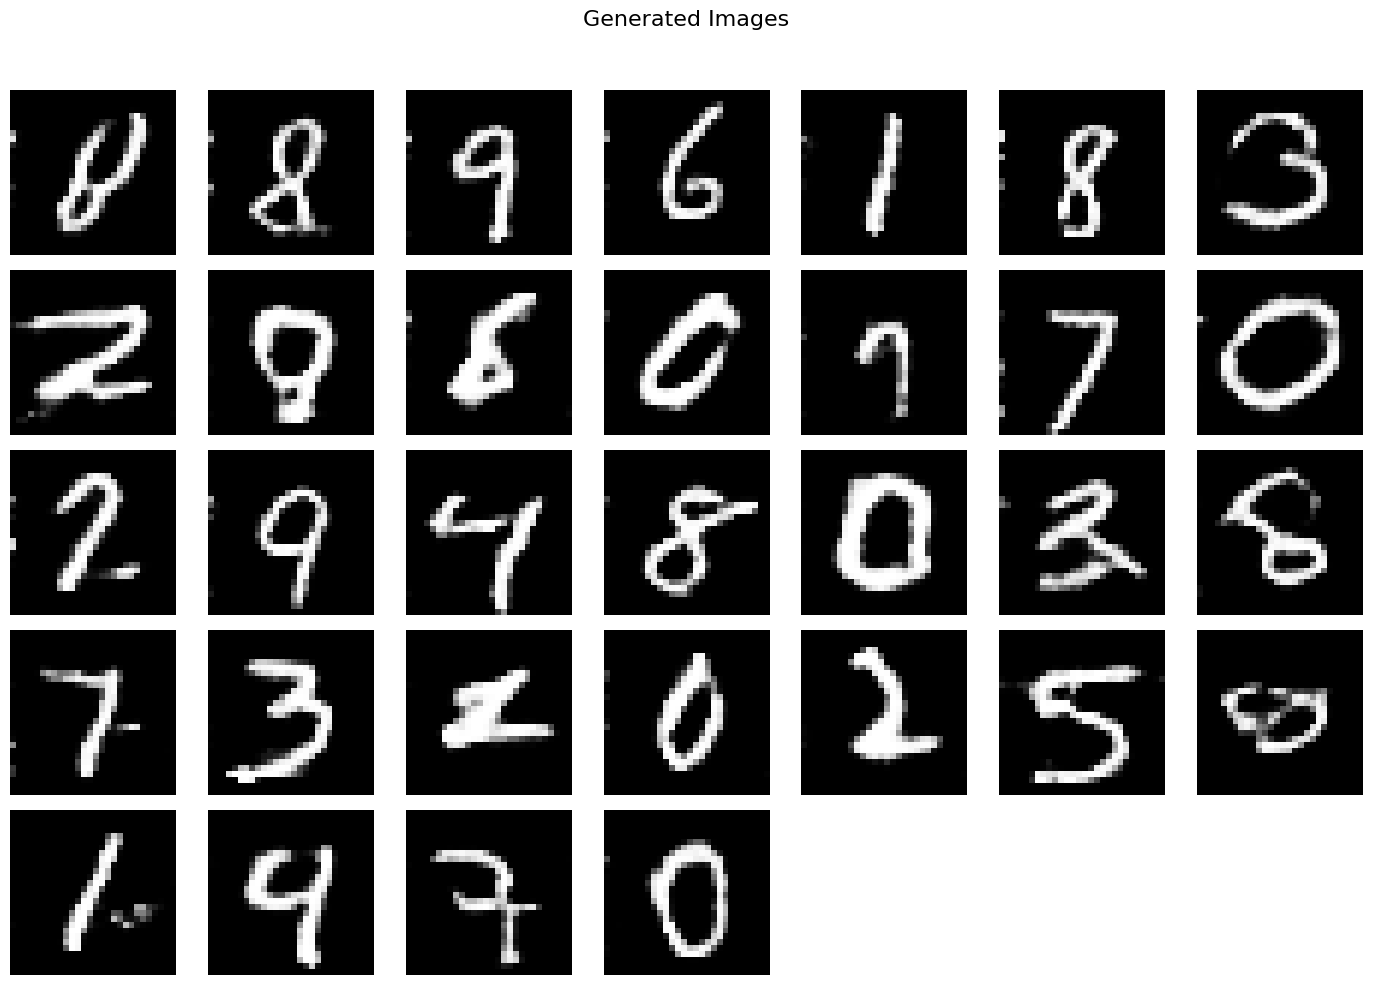

Checkpoint saved at models/checkpoint_epoch_32.pt
Epoch 32: G Loss: 0.759866, D Loss: 0.679091


Epoch 33/50: 100%|██████████| 1875/1875 [00:58<00:00, 31.91it/s]


Image saved to images/output_32.png


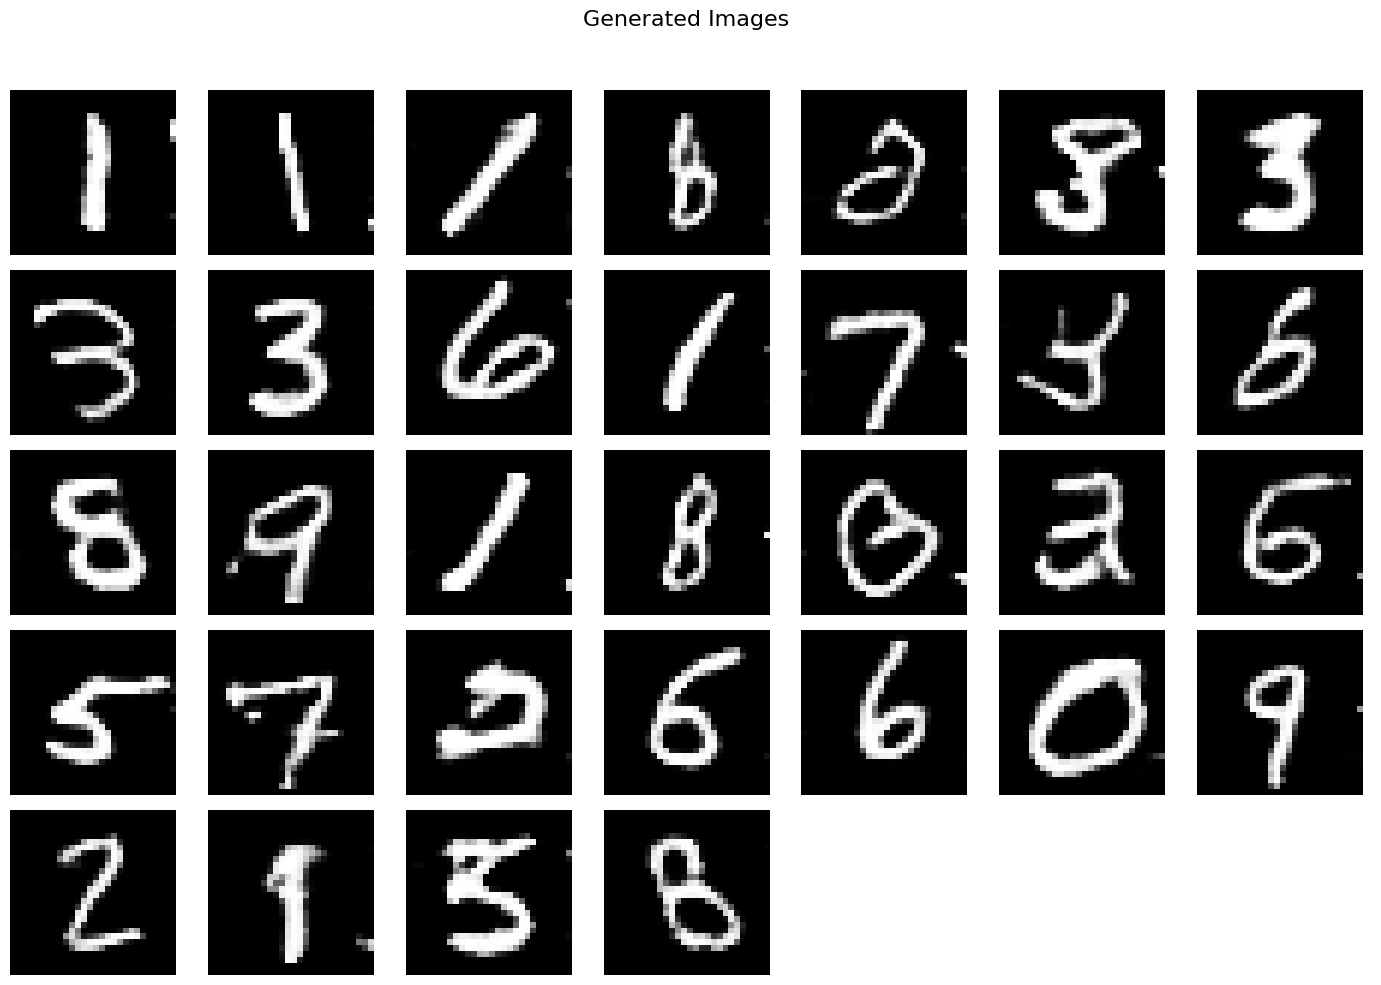

Checkpoint saved at models/checkpoint_epoch_33.pt
Epoch 33: G Loss: 0.771437, D Loss: 0.673293


Epoch 34/50: 100%|██████████| 1875/1875 [00:58<00:00, 31.86it/s]


Image saved to images/output_33.png


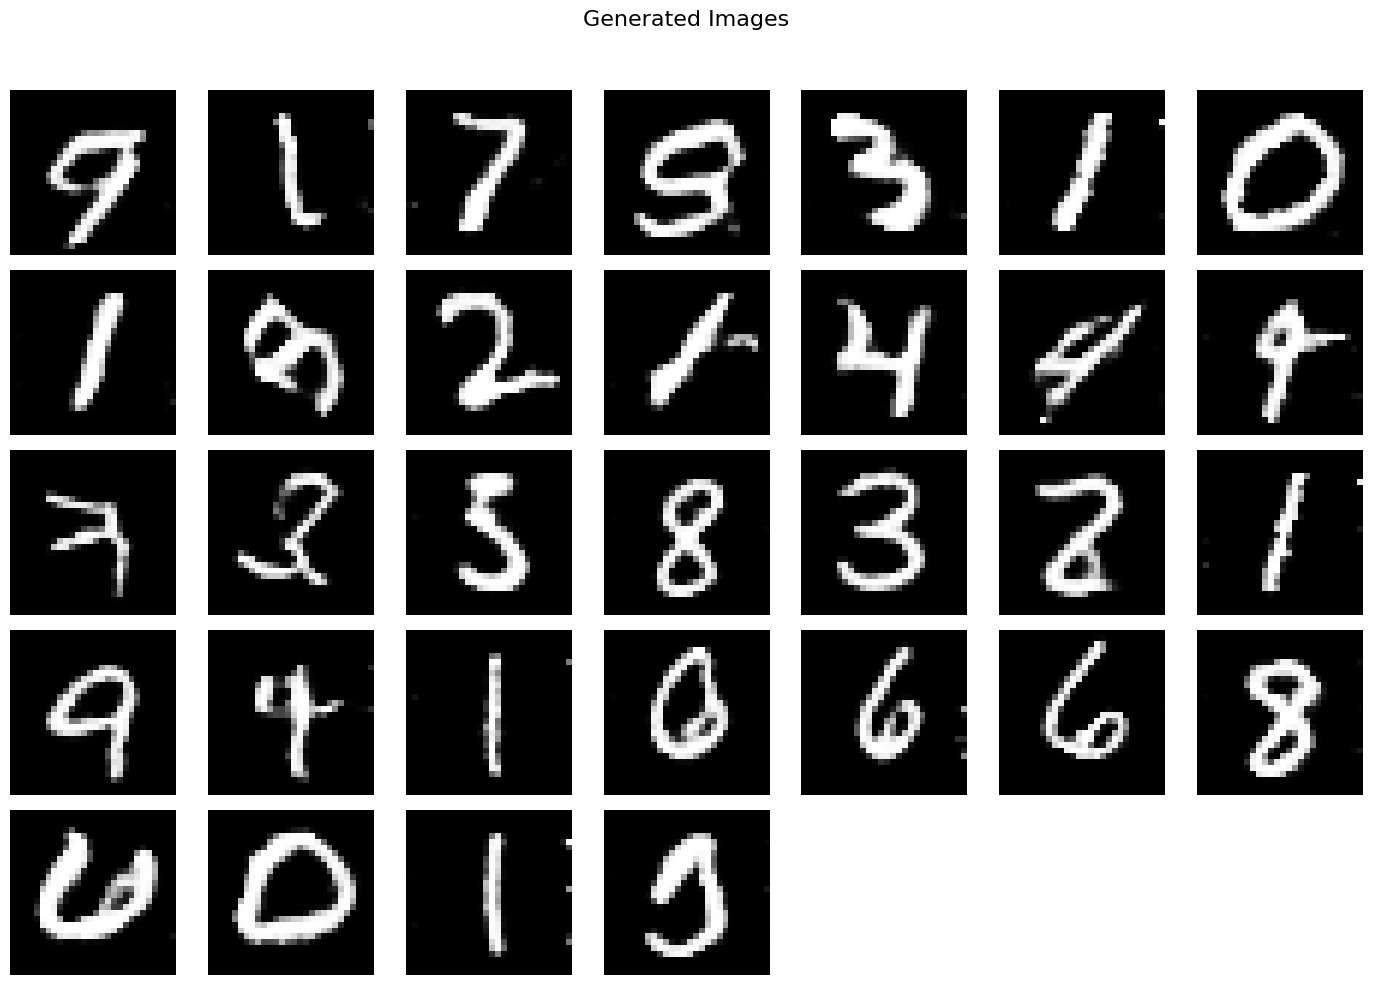

Checkpoint saved at models/checkpoint_epoch_34.pt
Epoch 34: G Loss: 0.792519, D Loss: 0.661133


Epoch 35/50:  45%|████▍     | 836/1875 [00:26<00:32, 31.74it/s]


RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=0

In [ ]:
def train(
    generator: nn.Module,
    discriminator: nn.Module,
    Goptimizer: optim.Optimizer,
    Doptimizer: optim.Optimizer,
    Gcriterion: nn.Module,
    Dcriterion: nn.Module,
    trainloader: DataLoader,
    epochs: int,
    latent_dim: int = 100,
    save_dirs: str = "models",
    checkpoint_interval: int = 1
) -> None:
    device = 'cuda'
    generator.to(device).train()
    discriminator.to(device).train()
    noise_scheduler = AdaptiveDiffusionScheduler(device=device)
    os.makedirs(save_dirs, exist_ok=True)
    os.makedirs("images", exist_ok=True)

    for epoch in range(epochs):
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        num_batches = 0

        for real_img, _ in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
            real_img = real_img.to(device)
            batch_size = real_img.size(0)
            num_batches += 1

            timesteps = noise_scheduler.sample_timesteps(batch_size)
            latent_noise = torch.randn(batch_size, latent_dim, device=device)
            fake_img = generator(latent_noise)

            # Discriminator
            Doptimizer.zero_grad()
            noised_real_img = noise_scheduler.apply_diffusion(real_img, timesteps)
            noised_fake_img = noise_scheduler.apply_diffusion(fake_img.detach(), timesteps)
            real_outputs = discriminator(noised_real_img)
            fake_outputs = discriminator(noised_fake_img)
            d_loss = Dcriterion(discriminator, noised_real_img, noised_fake_img, real_outputs, fake_outputs)
            d_loss.backward()
            Doptimizer.step()

            # Generator
            Goptimizer.zero_grad()
            noised_fake_img = noise_scheduler.apply_diffusion(fake_img, timesteps)
            fake_outputs = discriminator(noised_fake_img)
            g_loss = Gcriterion(fake_outputs)
            g_loss.backward()
            Goptimizer.step()

            noise_scheduler.update_schedule(d_loss.item())
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        inference(fake_img, 32, save_path=f"images/output_{epoch}.png")

        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(
                generator, discriminator,
                Goptimizer, Doptimizer,
                epoch=epoch+1,  # Save as 1-based epoch numbering
                save_dir=save_dirs
            )

        avg_g_loss = epoch_g_loss / num_batches
        avg_d_loss = epoch_d_loss / num_batches
        print(f"Epoch {epoch+1}: G Loss: {avg_g_loss:.6f}, D Loss: {avg_d_loss:.6f}")

# Example usage with MNIST
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # [-1, 1]
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

gen = Generator().to('cuda')
disc = Discriminator().to('cuda')
gopt = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
dopt = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
gcriterion = GeneratorLoss().to('cuda')
dcriterion = DiscriminatorLoss().to('cuda')

train(gen, disc, gopt, dopt, gcriterion, dcriterion, trainloader, epochs=50)
